Цель проекта заключается в создании модели машинного обучения, которая способна предсказывать уровень удовлетворенности сотрудников работой в компании на основе имеющихся данных. Для этого необходимо выполнить следующие задачи:

1. Предварительная обработка данных: получение данных о сотрудниках компании, включая их характеристики и уровень удовлетворенности, а также очистка и подготовка этих данных для анализа.

2. Исследовательский анализ данных: анализ основных характеристик сотрудников и их взаимосвязи с уровнем удовлетворенности работой. Выявление значимых признаков для построения модели.

3. Построение модели: Разработка и обучение модели машинного обучения на основе выбранных признаков, которая будет предсказывать уровень удовлетворенности сотрудников.

4. Оценка модели: Оценка качества и эффективности построенной модели на тестовых данных, используя соответствующие метрики оценки.

Помимо этого, вторая часть проекта будет заключаться в создании модели, способной предсказывать возможные случаи увольнения сотрудников на основе имеющихся данных. Эта задача также включает в себя предварительную обработку данных, исследовательский анализ факторов, влияющих на увольнение, построение и оценку модели.


In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from pandas.plotting import scatter_matrix
from phik import phik
from scipy import stats as st
from scipy.stats import shapiro

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression 
from sklearn.metrics import (accuracy_score, confusion_matrix, mean_absolute_error,
                             mean_squared_error, precision_recall_curve, precision_score, roc_curve, auc,
                             r2_score, recall_score, roc_auc_score, make_scorer, f1_score, classification_report)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   OrdinalEncoder, RobustScaler, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.inspection import permutation_importance


## Задание: предсказание уровня удовлетворённости сотрудника ##

В качестве первого задания нам предстоит построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

### Загрузка данных ###

Для выполнения первой задачи мы будем работать с тремя датасетами.

Загрузим и ознакомимся с данными первого файла. Он содержит тренировочную выборку, на которой мы будем обучать модель.

In [5]:
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')

In [6]:
train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Данные загружены корректно.

In [7]:
train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Файл состоит из 13 признаков и 4000 строк и содержит следующую информацию:

0. "id" — уникальный идентификатор сотрудника;
1. "dept" — отдел, в котором работает сотрудник;
2. "level" — уровень занимаемой должности;
3. "workload" — уровень загруженности сотрудника;
4. "employment_years" — длительность работы в компании (в годах);
5. "last_year_promo" — показывает, было ли повышение за последний год;
6. "last_year_violations" — показывает, нарушал ли сотрудник трудовой договор за последний год;
7. "supervisor_evaluation" — оценка качества работы сотрудника, которую дал руководитель;
8. "salary" — ежемесячная зарплата сотрудника;
9. "job_satisfaction_rate" — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Данные содержат пропуски в столбцах 'dept' и 'level', типы данных соответствуют содержимому, названия колонок в порядке.

Загрузим второй файл, который содержит входные признаки тестовой выборки.

In [8]:
X_test_job = pd.read_csv('/datasets/test_features.csv')

In [9]:
X_test_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [10]:
X_test_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Тестовая выборка содержит 2000 записей и 8 столбцов, пропуски в столбцах 'dept' и 'level' также обработаем позднее в пайплайне, типы данных в порядке.

In [11]:
set(X_test_job.columns).symmetric_difference(set(train_job.columns))

{'job_satisfaction_rate'}

Наименования столбцов входных признаков в тестовой и тренировочных выборках совпадают.

Загрузим и изучим третий файл.

In [12]:
y_test_job = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [13]:
y_test_job.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [14]:
y_test_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Датасет с целевым признаком содержит 2000 строк и 2 столбца, пропусков нет, типы данных соответствуют содержимому, но порядок id не совпадает с порядком в датасете с входными признаками, необходимо выравнять их.

**Вывод:** Данные для построения модели, предсказывающей уровень удовлетворенности сотрудников, загружены. В тренировочной выборке и тестовых входных признаках обнаружены пропуски, типы данных и наименования колонок в порядке.

### Предобработка данных ###

Выявленные пропуски обработаем в пайплайне на этапе подготовки данных к моделированию. Проверим датасеты на наличие дубликатов, но сначала приведем все строковые значения к нижнему регистру и в качестве индексов используем номер идентификационного номера.

In [15]:
def lowercase_strings(data):
    return data.applymap(lambda x: x.lower() if isinstance (x, str) else x)
train_job = lowercase_strings(train_job)
train_job = train_job.set_index('id')

In [16]:
train_job.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [17]:
train_job.duplicated().sum()

245

В датасете train_job 245 явных дубликата, значение совпадают по всем столбцам, удалим их.

In [18]:
train_job = train_job.drop_duplicates()

In [19]:
train_job.duplicated().sum()

0

In [20]:
train_job.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


После удаления явных дубликатов осталось 3755 записей. Теперь проверим наличие неявных, для этого выведем уникальные значения для всех текстовых столбцов.

In [21]:
def show_unique(data):
    text_cols = data.select_dtypes(include=['object']).columns
    for col in text_cols:
        print(f"Уникальные значения в {col}:", data[col].unique())
show_unique(train_job)

Уникальные значения в dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в workload: ['medium' 'high' 'low']
Уникальные значения в last_year_promo: ['no' 'yes']
Уникальные значения в last_year_violations: ['no' 'yes']


Дублирующихся значений нет, исправим грамматическую ошибку в слове "senior".

In [22]:
train_job['level'].replace('sinior', 'senior', inplace=True)
train_job['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

Для лучшего представления о данных рассмотрим количество уникальных значений во всех столбцах.

In [23]:
train_job.nunique()

dept                      5
level                     3
workload                  3
employment_years         10
last_year_promo           2
last_year_violations      2
supervisor_evaluation     5
salary                   68
job_satisfaction_rate    98
dtype: int64

'last_year_promo' и 'last_year_violations' - бинарные признаки, а количественные 'supervisor_evaluation' и 'employment_years' могут быть дискретными.

In [24]:
(
    train_job.isna()
    .agg(['sum', lambda x: x.mean()*100]).T
    .astype({'sum': 'int'})
    .rename(columns={'sum': 'Количество пропусков', '<lambda>': 'Процент пропусков'})
    .assign(**{'Процент пропусков': lambda x: x['Процент пропусков'].apply(lambda x: f'{x:.2f}%')})
)

,Количество пропусков,Процент пропусков
dept,6,0.16%
level,4,0.11%
workload,0,0.00%
employment_years,0,0.00%
last_year_promo,0,0.00%
last_year_violations,0,0.00%
supervisor_evaluation,0,0.00%
salary,0,0.00%
job_satisfaction_rate,0,0.00%


Тренировочные данные содержат 10 пропусков: 6 в столбце 'dept' и 4 - в 'level'. Мы уже определили, что обрабатывать их будем в препроцессоре нашего пайплайна.

Теперь приведем индексы в тестовых данных к единству. Для этого сначала отсортируем колонку id, потому что нам важен одинаковый порядок записей в обоих датасетах, и установим ее в качестве индексов.

In [25]:
y_test_job = y_test_job.sort_values(by='id')
X_test_job = X_test_job.sort_values(by='id')

In [26]:
if y_test_job['id'].equals(X_test_job['id']):
    print('Значения в двух столбцах совпадают.')
else:
    print('Значения в двух столбцах не совпадают.')

Значения в двух столбцах не совпадают.


In [27]:
if X_test_job.index.equals(y_test_job.index):
    print('Индексы одинаковые.')
else:
    print('Индексы разные.')

Индексы разные.


In [28]:
X_test_job = X_test_job.set_index('id')
y_test_job = y_test_job.set_index('id')

In [29]:
if X_test_job.index.equals(y_test_job.index):
    print('Индексы одинаковые.')
else:
    print('Индексы разные.')

Индексы одинаковые.


Теперь в  X_test_job приведем все строковые значения к нижнему регистру.

In [30]:
X_test_job = lowercase_strings(X_test_job)

In [31]:
X_test_job.duplicated().sum()

557

В датасете с тестовыми данными 557 явных дубликатов. В нашей случае тестовая выборка используется для оценки качества работы модели машинного обучения в качестве имитации новых, ранее не виденных ей данных. Поскольку оценка качества модели основана на способности модели обобщать информацию, удаление дубликатов из тестовой выборки может исказить этот процесс оценки.

Посмотрим на уникальные значения датасета X_test_job.

In [32]:
show_unique(X_test_job)

Уникальные значения в dept: ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
Уникальные значения в level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в workload: ['low' 'high' 'medium' ' ']
Уникальные значения в last_year_promo: ['no' 'yes']
Уникальные значения в last_year_violations: ['no' 'yes']


В столбце dept и workload появилось значение ' '.

In [33]:
X_test_job[(X_test_job == ' ').any(axis=1)]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
590867,marketing,junior,,4,no,no,4,28800
822186,,middle,medium,3,no,no,4,38400


Всего две записи. Можно заменить ' ' на nan, но лучше сделать это на этапе предобработки в пайплайне.

Снова изменим опечатку в 'senior'.

In [34]:
X_test_job['level'].replace('sinior', 'senior', inplace=True)
X_test_job['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [35]:
(
    X_test_job.isna()
    .agg(['sum', lambda x: x.mean()*100]).T
    .astype({'sum': 'int'})
    .rename(columns={'sum': 'Количество пропусков', '<lambda>': 'Процент пропусков'})
    .assign(**{'Процент пропусков': lambda x: x['Процент пропусков'].apply(lambda x: f'{x:.2f}%')})
)

,Количество пропусков,Процент пропусков
dept,2,0.10%
level,1,0.05%
workload,0,0.00%
employment_years,0,0.00%
last_year_promo,0,0.00%
last_year_violations,0,0.00%
supervisor_evaluation,0,0.00%
salary,0,0.00%


Итак, сейчас в таблице с вводными тестовыми признаками 3 пропуска: 2 в столбце 'dept' и один в 'level'. 

Проверим соотношение количества строк в тестовых и тренировочных данных.

In [36]:
print(f"Соотношение размера тренировочной и тестовой выборки: тренировочная {train_job.shape[0]/(train_job.shape[0]+X_test_job.shape[0])*100:.2f}%, тестовая {X_test_job.shape[0]/(train_job.shape[0]+X_test_job.shape[0])*100:.2f}%")

Соотношение размера тренировочной и тестовой выборки: тренировочная 65.25%, тестовая 34.75%


**Вывод:** На этапе предобработки данных мы избавились от дубликатов в тренировочных данных, сделали одинаковым порядок значений тестовых данных, чтобы целовой признак соответствовал признакам, которые мы используем для тестирования модели. Также мы обнаружили лишнее значение (пробел) в категориальных тестовых данных, всместе с пропусками исправим в предобработчике пайплайна.

### Исследовательский анализ данных ###

Изучим количественные признаки датасета train_job.

In [37]:
train_job.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,3755.0,3.817044,2.557142,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,3755.0,3.463648,1.026265,1.00,3.00,4.00,4.00,5.0
salary,3755.0,34457.416778,15050.643870,12000.00,22800.00,31200.00,44400.00,98400.0
job_satisfaction_rate,3755.0,0.532554,0.226393,0.03,0.35,0.55,0.71,1.0


Как мы уже определили ранее, столбцы "employment_years" и "supervisor_evaluation" содержат дискретные величины, поэтому построим для них countplot графики.

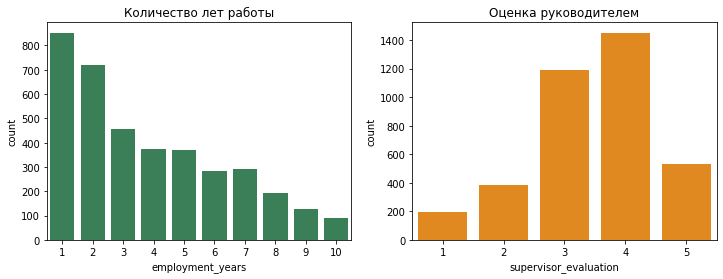

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=train_job['employment_years'], ax=axs[0], color='seagreen')
axs[0].set_title('Количество лет работы')
sns.countplot(x=train_job['supervisor_evaluation'], ax=axs[1], color='darkorange')
axs[1].set_title('Оценка руководителем')
plt.show()

Половина сотрудников работает в компании менее 4 лет, совсем небольшое количество людей трудятся на компанию больше 8 лет, с ростом стажа замечаем уменьшение количества человек в каждой группе. График напоминает распределение Пуассона. Чаще всего коллектив получает от начальника оценку работы 3 и 4. 1, 2 и 5 ставят реже, меньше всего оценок 1. 

Для оценки распределения 'salary' и 'job_satisfaction_rate' построим гистограммы и графики боксплот.

In [39]:
def dif_graphics(data):
    for column in data:
        if column in ['employment_years', 'supervisor_evaluation']:
            continue
        if data[column].dtype in ['int64', 'float64']:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            sns.histplot(data[column], kde=False, bins=50, ax=axes[0], color='salmon')
            axes[0].set_title(f'Гистограмма {column}')
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Количество')
            
            sns.boxplot(x=data[column], ax=axes[1], color='orange')
            axes[1].set_title(f'Boxplot для столбца {column}')
            axes[1].set_xlabel(column)
            plt.show()

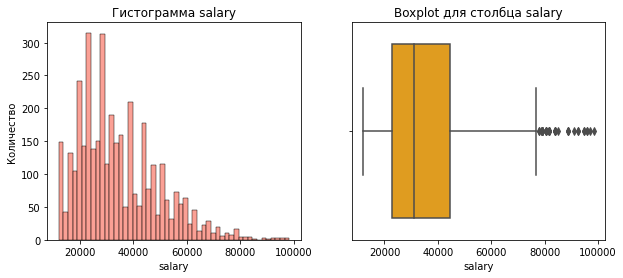

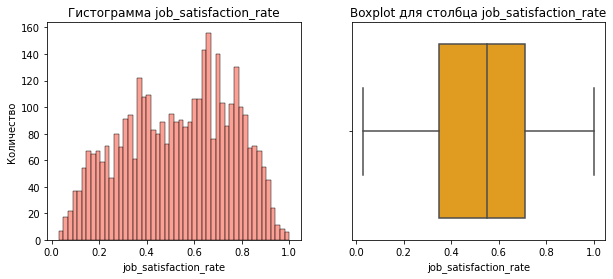

In [40]:
dif_graphics(train_job)

In [41]:
num_cols_job = train_job.select_dtypes(include=['int64', 'float64']).columns.tolist()
for column in num_cols_job:
    stat, p_value = shapiro(train_job[column])
    
    if p_value < 0.05:
        print(f'{column}: Не нормальное распределение')
    else:
        print(f'{column}: Нормальное распределение')

employment_years: Не нормальное распределение
supervisor_evaluation: Не нормальное распределение
salary: Не нормальное распределение
job_satisfaction_rate: Не нормальное распределение


Количественные признаки тестовых данных распределены ненормально. Они не содержат выбросов и аномалий. 75% сотрудников получают зарплату до 47 тыс. при диапазоне данных 12- 98,4. Гистограмма оценок удовлетворенностью работой содержит два пика на отметках около 0,38 и 0,65.

Посмотрим на распределение качественных признаков.

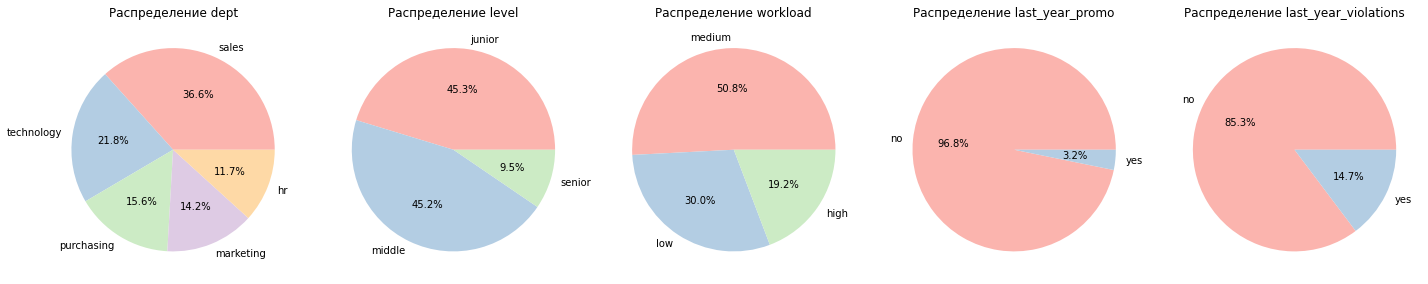

In [42]:
cat_cols_job= train_job.select_dtypes(include='object').columns.tolist()
fig, axes = plt.subplots(nrows=1, ncols=len(cat_cols_job), figsize=(20, 5))
for i, col in enumerate(cat_cols_job):
    train_job[col].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[i], colors=sns.color_palette('Pastel1'))
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

На основании круговых диграмм, можно сделать выводы о том, что доли сотрудников уровня middle и  junior почти равни, а доля senior всего 9,5%. Сильно загружены 19,2% работников, 50,8% имеют среднюю нагрузку, а легкая степень загрузки - у 30%. В прошлом году повышение получили всего 3,2%, но нарушения трудового договора совершили 14,7%. Распределение отделов мы исследуем дополнительно с помощью графика countplot.

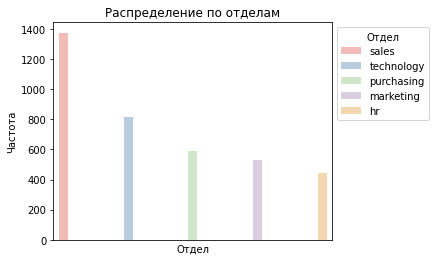

In [43]:
plt.figure(figsize=(5, 4))
sns.countplot(x='dept',data=train_job, hue='dept',dodge=True, 
              order=train_job['dept'].value_counts().index,
              hue_order=train_job['dept'].value_counts().index,
              palette='Pastel1')
plt.title('Распределение по отделам', fontdict={'fontsize': 12})
plt.ylabel('Частота')
plt.xlabel('Отдел')
plt.legend(title='Отдел', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks([])
plt.show()

Чаще всего мы встречаем информацию об отделе продаж, наименьшее количество записей в выборке об отделе кадров.

Теперь изучим тестовые данные.

In [44]:
X_test_job.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Среднее значение трудового стажа немного ниже в тестовой выборке, но медианы равны. Медиана оценки начальника в тестовой выборке равна 4, а в тренировочной 3. Средняя зарплата отличается незначительно, как и медиана.

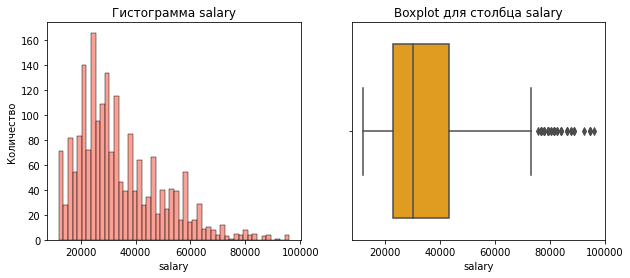

In [45]:
dif_graphics(X_test_job)

График распределения заработной платы в тестовой выборке похож на распределение в тренировочных данных, большинство значений расположены на отметке до 50 т. Очевидно, что распределении имеет форму ненормального.

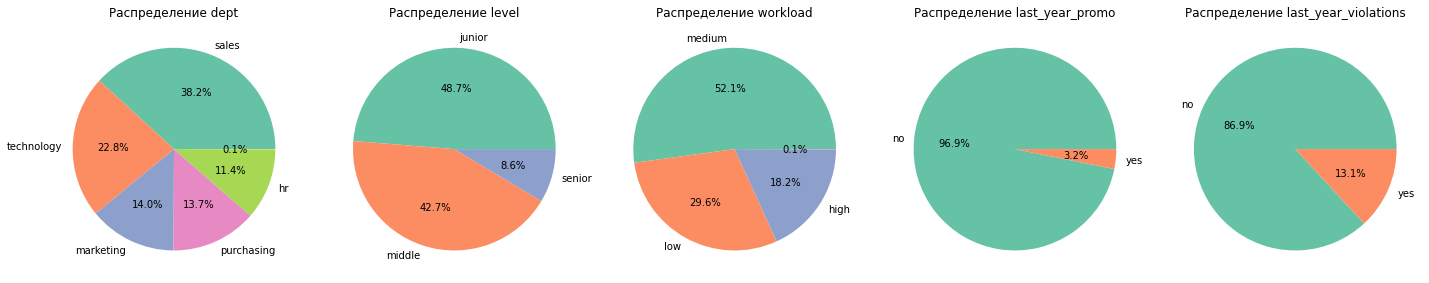

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=len(cat_cols_job), figsize=(20, 5))
for i, col in enumerate(cat_cols_job):
    X_test_job[col].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[i], colors=sns.color_palette('Set2'))
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

Процент сотрудников уровня senior в тестовых данных немного меньше, а средне загруженных работников больше на 2 процентных пункта. Количество нарушений меньше почти на 2 процента.


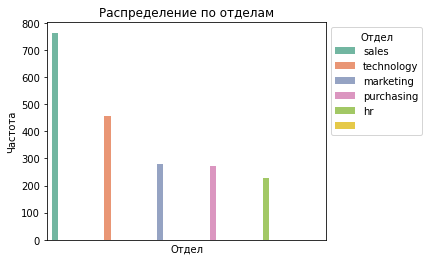

In [47]:
plt.figure(figsize=(5, 4))
sns.countplot(x='dept',data=X_test_job, hue='dept',dodge=True, 
              order=X_test_job['dept'].value_counts().index,
              hue_order=X_test_job['dept'].value_counts().index,
              palette='Set2')
plt.title('Распределение по отделам', fontdict={'fontsize': 12})
plt.ylabel('Частота')
plt.xlabel('Отдел')
plt.legend(title='Отдел', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks([])
plt.show()

Доля отдела закупок в тестовых данных меньше, а отдела продаж незначительно больше.

In [48]:
y_test_job.describe().T

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.54878,0.22011,0.03,0.38,0.58,0.72,1.0


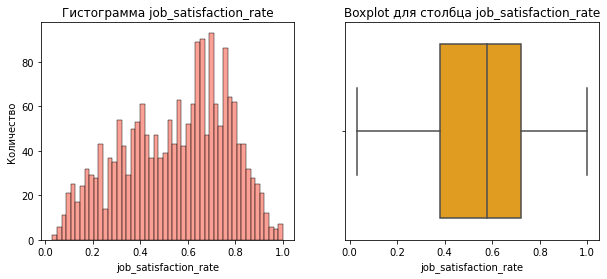

In [49]:
dif_graphics(y_test_job)

Среднее и медиана оценок удовлетворенности сотрудников в тестовой выборке больше, чем в тренировочных данных, но незначительно. График распределения смещен вправо, диапазон данных совпадает.

Проведем корреляционный анализ тренировочных данных, для этого построим матрицу phik.

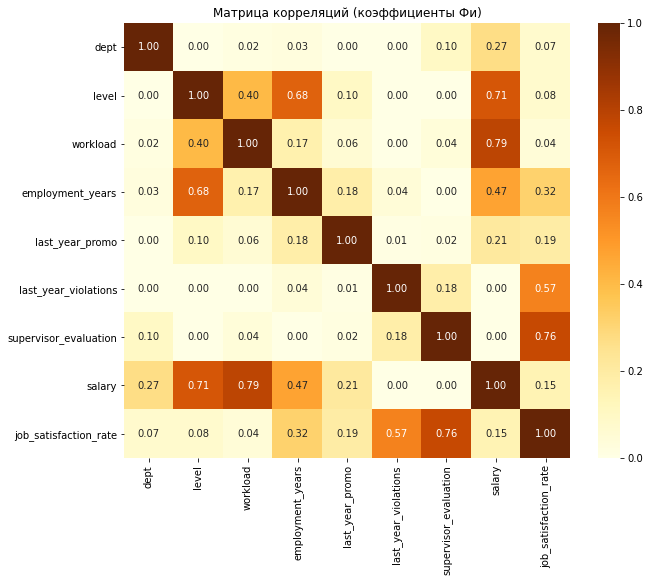

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_job.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.2f', cmap='YlOrBr')
plt.title('Матрица корреляций (коэффициенты Фи)', fontdict={'fontsize': 12})
plt.show()

Сильную корреляцию с целевым имеют признаки 'last_year_violations' и 'supervisor_evaluation'. Между признаками 'workload' и 'salary', 'level' и 'salary', 'employment_years' и 'level' также присутствует сильная взаимосвязь. Из-за того, что значения признаков распределены ненормально, используем для анализа корреляции метод Спирмена.

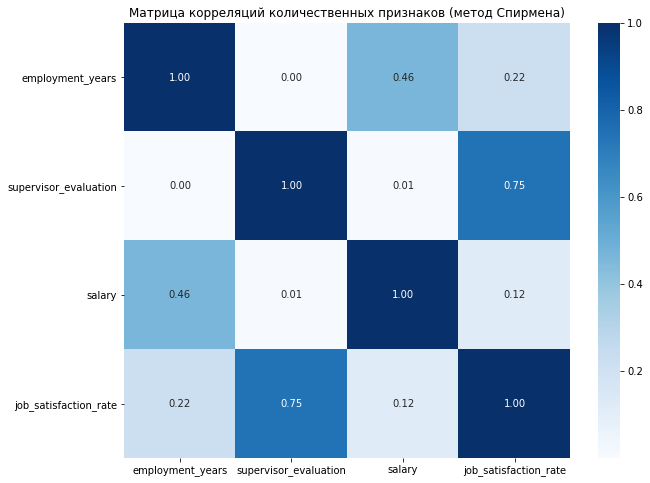

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_job[num_cols_job].corr(method='spearman'), annot=True, fmt='.2f', cmap='Blues')
plt.title('Матрица корреляций количественных признаков (метод Спирмена)', fontdict={'fontsize': 12})
plt.show()

Коэффициенты корреляции изменились несильно. Посмотрим на графики зависимости сильно коррелирующих с целевым признаков. 

In [52]:
supervisor_pivot = train_job.pivot_table(index='supervisor_evaluation', values='job_satisfaction_rate', aggfunc='median')

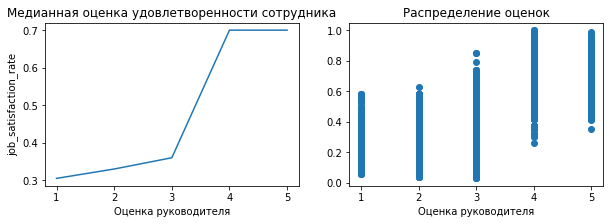

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
sns.lineplot(x=supervisor_pivot.index, y='job_satisfaction_rate', data=supervisor_pivot, ax=axes[0])
axes[0].set_title('Медианная оценка удовлетворенности сотрудника')
axes[0].set_xlabel('Оценка руководителя')

axes[1].scatter(x=train_job['supervisor_evaluation'], y=train_job['job_satisfaction_rate'])
axes[1].set_xlabel('Оценка руководителя')
axes[1].set_title('Распределение оценок')
plt.show()

Сотрудники, которые получили хорошие оценки от руководителей получают большее удовольствие от работы.

In [54]:
violations_pivot = train_job.pivot_table(index='last_year_violations', values='job_satisfaction_rate', aggfunc='median')

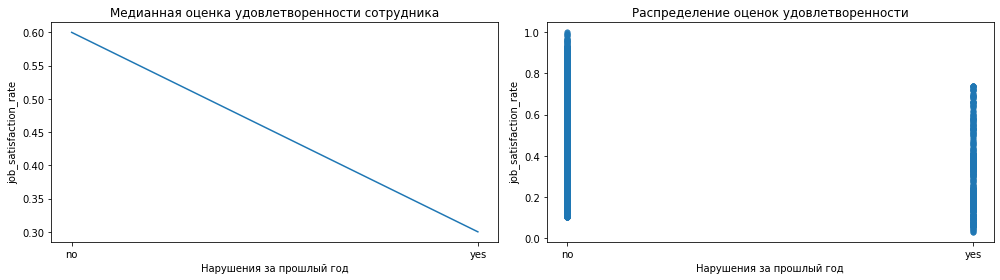

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.lineplot(x=violations_pivot.index, y='job_satisfaction_rate', data=violations_pivot, ax=axes[0])
axes[0].set_title('Медианная оценка удовлетворенности сотрудника')
axes[0].set_xlabel('Нарушения за прошлый год')
sns.scatterplot(x='last_year_violations', y='job_satisfaction_rate', palette='Set2', linewidth=0, alpha=0.7, data=train_job, ax=axes[1])
axes[1].set_title('Распределение оценок удовлетворенности')
axes[1].set_xlabel('Нарушения за прошлый год')

plt.tight_layout()  
plt.show()

Сотрудники, которые допускали в прошлом году нарушения трудового договора, в среднем ниже оценивают удовлетворенность работой.

In [56]:
workload_pivot = train_job.pivot_table(index='workload', values='salary', aggfunc='median').sort_values(by='salary')

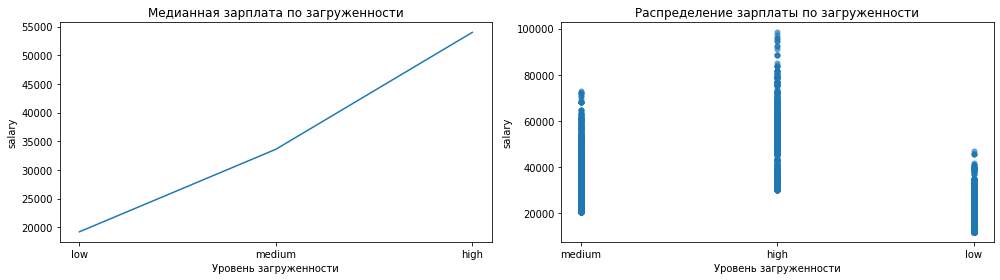

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.lineplot(x=workload_pivot.index, y='salary', data=workload_pivot, ax=axes[0])
axes[0].set_title('Медианная зарплата по загруженности')
axes[0].set_xlabel('Уровень загруженности')
sns.scatterplot(x='workload', y='salary', palette='Set2', linewidth=0, alpha=0.7, data=train_job, ax=axes[1])
axes[1].set_title('Распределение зарплаты по загруженности')
axes[1].set_xlabel('Уровень загруженности')

plt.tight_layout()  
plt.show()

Слабо загруженные сотрудники получают меньшую зарплату, а сильнозагруженные - высокую.

In [58]:
level_pivot = train_job.pivot_table(index='level', values='salary', aggfunc='median').sort_values(by='salary')

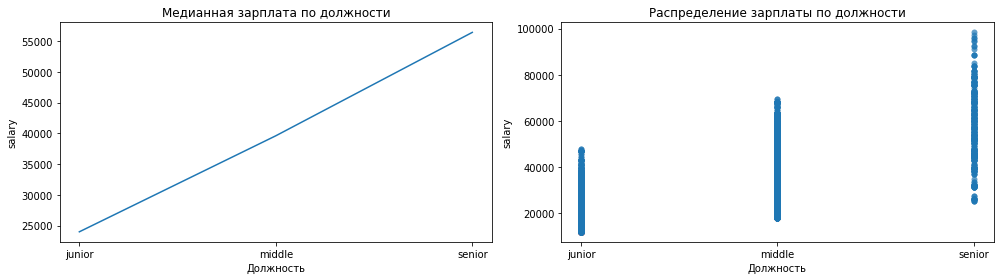

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.lineplot(x=level_pivot.index, y='salary', data=level_pivot, ax=axes[0])
axes[0].set_title('Медианная зарплата по должности')
axes[0].set_xlabel('Должность')
sns.scatterplot(x='level', y='salary', palette='Set2', linewidth=0, alpha=0.7, data=train_job, ax=axes[1])
axes[1].set_title('Распределение зарплаты по должности')
axes[1].set_xlabel('Должность')

plt.tight_layout()  
plt.show()

Медианная зарплата увеличивается в зависимости от должности.

In [60]:
years_pivot = train_job.pivot_table(index='level', values='employment_years', aggfunc='median').sort_values(by='employment_years')

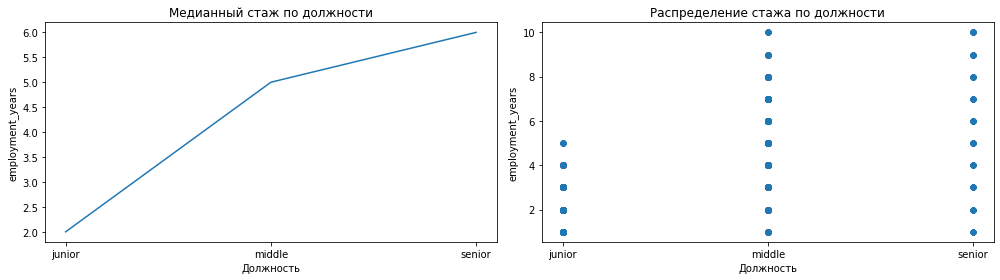

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.lineplot(x=years_pivot.index, y='employment_years', data=years_pivot, ax=axes[0])
axes[0].set_title('Медианный стаж по должности')
axes[0].set_xlabel('Должность')
sns.scatterplot(x='level', y='employment_years', palette='Set2', linewidth=0, alpha=0.7, data=train_job, ax=axes[1])
axes[1].set_title('Распределение стажа по должности')
axes[1].set_xlabel('Должность')

plt.tight_layout()  
plt.show()

Медианный стаж также растет вместе с уровнем сотрудника - джуны обычно работают в компании около 2 лет, а сениоры - около 6 лет.

Построим на график зависимости средних оценок удовлетворенности сотрудников от стажа работы 

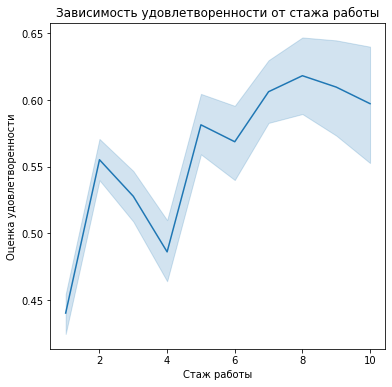

In [62]:
plt.figure(figsize=(6,6))
sns.lineplot(x='employment_years', y='job_satisfaction_rate', data=train_job)
plt.title('Зависимость удовлетворенности от стажа работы')
plt.xlabel('Стаж работы')
plt.ylabel('Оценка удовлетворенности')
plt.show()


После 5 лет работы в компании среднее удовлетворенности сотрудников растет. В свой первый год работы люди склонны к недовольству, но по результатам второго года их мнение улучшается. Как мы установили ранее, штат половины работников не превышает 4 лет, т.е. в этом диапазоне состредоточено большое количество значений, особенно на отметках 1 и 2. На основании графика можно предположить наличие следующих пяти групп: 1 год, 2 года, 3-4 года, 5-7 лет, 8 и более.

Посмотрим на взаимосвязи между признаками в тестовой выборке.

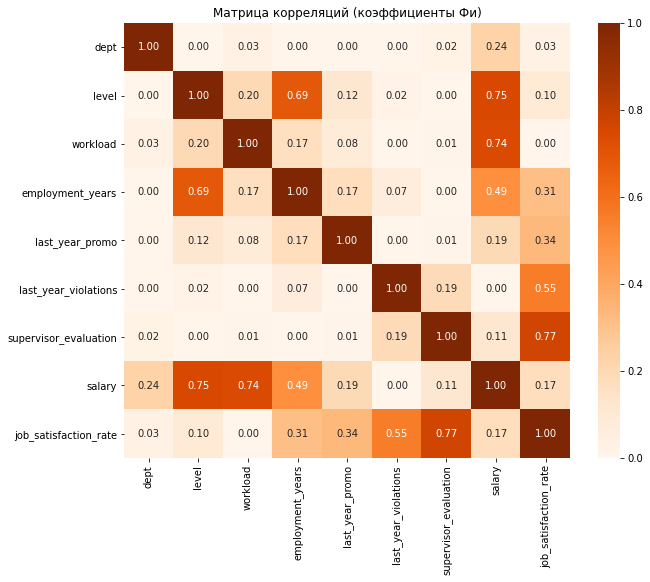

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.concat([X_test_job, y_test_job], axis=1).phik_matrix(interval_cols=('salary', 'job_satisfaction_rate')), annot=True, fmt='.2f', cmap='Oranges')
plt.title('Матрица корреляций (коэффициенты Фи)', fontdict={'fontsize': 12})
plt.show()

Сила коррелляции между признаками сохраняется идентичной в тренировочных данных.

**Вывод:** Количественные признаки в данных распределены ненормально, 'level', 'workload' и 'supervisor_evaluation' являются категориальными порядковыми признаками, между категориями этих признаков есть логичная связь. С целевым признаком сильную корреляцию имеют признаки  'last_year_violations' и 'supervisor_evaluation'. Между признаками 'workload' и 'salary', 'level' и 'salary', 'employment_years' и 'level' также присутствует сильная взаимосвязь.

### Подготовка признаков ###

Произведем разделение обучающего датасета на целевой и входные признаки.

In [64]:
X_train_job = train_job.drop('job_satisfaction_rate', axis=1)
y_train_job = train_job['job_satisfaction_rate']

In [65]:
X_train_job.shape, y_train_job.shape

((3755, 8), (3755,))

Установим RANDOM_STATE на определенное значение, например, 42, чтобы воспроизвести результаты при каждом запуске программы

In [66]:
RANDOM_STATE = 42

Для начала создадим списки столбцов для кодирования и масштабирования.

In [67]:
cols_ohe_1 = ['dept', 'last_year_promo', 'last_year_violations']
cols_ord_1 = ['level', 'workload']
cols_num_1 = ['salary']
cols_pass_1 = ['supervisor_evaluation', 'employment_years']

Столбец "supervisor_evaluation" уже содержит порядковые значения оценок от 1 до 5, а 'employment_years' - значения проработанных лет, которые лежат в диапазоне от 1 до 10, поэтому, чтобы не усложнять модель, не будем присваивать им отдельные категории, а предоставим эти данные модели в неизменном виде.
 
По результатам предобработки данных в начале проекта, мы помним, что признаки 'dept' и 'workload' в тестовой выборке содержат лишнее значение - ' ', также в столбцах 'dept' и 'level' присутствуют пропуски.

Создадим пайплайн для подготовки категориальных номинальных признаков из списка cols_ohe_1, параметру handle_unknown передадим значение 'ignore', чтобы неизвестные категории были проигнорированы, и в преобразованной строке все новые признаки стали нулевыми. Пропущенные значения заменим на самые частые с помощью SimpleImputer.

In [68]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Теперь создадим пайплайн для подготовки признаков из списка cols_ord_1, пропуски снова заполним часто встречающимися значениями, а отсутствующую категорию " " заменим на пропуск, а потом снова избавимся от пропусков заполнением популярными значениями.

In [69]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Создадим общий пайплайн для подготовки данных.

In [70]:
preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cols_ohe_1),
        ('ord', ord_pipe, cols_ord_1),
        ('num', StandardScaler(), cols_num_1),
        ('pass', 'passthrough', cols_pass_1)
    ], 
    remainder='passthrough'
) 

Перед нами стоит задача регрессии, поэтому для оценки качества модели мы будем использовать метрику SMAPE (symmetric mean absolute percentage error), она измеряет среднее абсолютное процентное отклонение между фактическими и прогнозными значениями. Критерий успеха: SMAPE ≤15 на тестовой выборке, значит параметр greater_is_better надо переключить на False, чтобы модель стремилась к уменьшению значения метрики, но при этом стоит ожидать возвращения отрицательных значений, чтобы получить модуль в таких случаях, будем умножать получившееся отрицательное значение на -1.

In [71]:
def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
smape_score = make_scorer(smape, greater_is_better = False)

**Вывод:** На этом этапе из тренировочных данных мы выделили целевой признак, создали общий пайплайн для подготовки данных с учетом всех их особенностей, также мы подготовили метрику для оценки качества модели. 

### Обучение моделей ###

Для определения лучшей мы обучим две модели: модель линейной регрессии и дерево решений, а также переберем основные гиперпараметры для них. Затем с помощью метрики SMAPE сделаем выбор и проверим качество модели на тестовых данных.

In [72]:
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessing),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [73]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split':range(2, 20),
        'models__min_samples_leaf':range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }]

random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    error_score='raise',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=150
)

In [74]:
random_search.fit(X_train_job, y_train_job) 
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели по кросс-валидации', random_search.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

С помощью случайного поиска была выбрана модель регрессии, основанная на алгоритме дерева решений, где каждый узел представляет собой проверку определенного признака, а каждый лист дерева представляет собой конечное предсказание. Гиперпараметры лучшей модели:
- max_depth=19: Этот параметр определяет максимальную глубину дерева решений,
- min_samples_leaf=2: Этот параметр задает минимальное количество образцов, которое должно находиться в листовом узле дерева. Установка этого параметра на значение "2" означает, что каждый лист дерева должен содержать как минимум 2 образца,
- min_samples_split=6: Этот параметр определяет минимальное количество образцов, необходимых для разделения внутреннего узла. Установка его на значение "6" требует, чтобы узел был разделен только в том случае, если в нем содержится как минимум 6 образцов.

Числовые признаки были отмасштабированы с помощью параметра 'MinMaxScaler()'.

Посмотрим, какие 15 вариантов моделей имели лучшие средние метрики на кросс-валидации среди всех рассмотренных.

In [75]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(random_search.cv_results_) 
result['mean_test_score'] = result['mean_test_score']*-1
result.sort_values('rank_test_score')[['rank_test_score', 'param_models', 'mean_test_score','params']].head(15)

,rank_test_score,param_models,mean_test_score,params
109,1,DecisionTreeRegressor(random_state=42),15.199441,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 2, 'models__max_depth': 19, 'models': DecisionTreeRegressor(random_state=42)}"
101,2,DecisionTreeRegressor(random_state=42),15.200768,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 8, 'models__min_samples_leaf': 3, 'models__max_depth': 18, 'models': DecisionTreeRegressor(random_state=42)}"
100,3,DecisionTreeRegressor(random_state=42),15.211596,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 8, 'models__min_samples_leaf': 3, 'models__max_depth': 19, 'models': DecisionTreeRegressor(random_state=42)}"
97,4,DecisionTreeRegressor(random_state=42),15.286452,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 8, 'models__min_samples_leaf': 3, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}"
135,5,DecisionTreeRegressor(random_state=42),15.335490,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 15, 'models__min_samples_leaf': 2, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=42)}"
99,6,DecisionTreeRegressor(random_state=42),15.357865,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 12, 'models__min_samples_leaf': 3, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}"
68,7,DecisionTreeRegressor(random_state=42),15.368988,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 13, 'models__min_samples_leaf': 2, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}"
88,8,DecisionTreeRegressor(random_state=42),15.392109,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
67,9,DecisionTreeRegressor(random_state=42),15.394260,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
119,10,DecisionTreeRegressor(random_state=42),15.395045,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 3, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"


Все модели с лучшей метрикой являются DecisionTreeRegressor с максимальной глубиной от 12 и выше, минимальным количеством образцов во внутреннем узле от 2 до 16 и в листовом узле от 2 до 5. 

In [76]:
total_combinations = 1
for params in param_grid:
    values_count = [len(value) for value in params.values()]
    total_combinations *= sum(values_count)

print('Общее количество комбинаций:', total_combinations)

Общее количество комбинаций: 184


Всего было составлено 184 комбинации, в пайплайне были рассчитаны метрики для 150 из них.

In [77]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_job)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [78]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary']),
                                                 ('pass', 'passthrough',
                                                  ['supervisor_evaluation',
                                                   'employment_years'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=19, min_samples_leaf=2,
                                       min_samples_split=6, random_state=42))])

In [79]:
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test_job["job_satisfaction_rate"], y_pred)}')

Метрика SMAPE на тестовой выборке: 13.666746610534341


SMAPE на тестовой выборке показала результат меньше 15, это соответствует требованию задачи.

Сравним качество предсказаний с базовой моделью DummyRegressor.

In [80]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_job, y_train_job)

y_pred_dummy = dummy_reg.predict(X_test_job)
print(f'Метрика SMAPE на тестовой выборке при использовании базовых предсказаний среднего значения: {smape(y_test_job["job_satisfaction_rate"], y_pred_dummy)}')

Метрика SMAPE на тестовой выборке при использовании базовых предсказаний среднего значения: 38.26225790202238


Обученная модель DecisionTreeRegressor показывает результаты метрики SMAPE на тестовых данных значительно лучшие, чем DummyRegressor, это значит, что модель действительно извлекает смысл из данных и находит полезные зависимости.

Посмотрим, как распределяется на графиках разница между фактическими и предсказанными значениями.

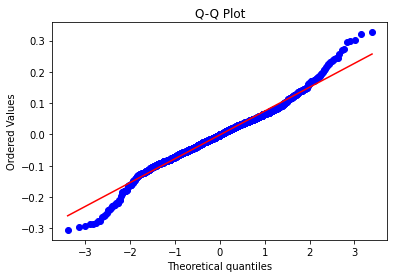

In [81]:
residuals = y_test_job["job_satisfaction_rate"] - y_pred
st.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q Plot')
plt.show()

Остатки распределены ненормально, значит выбор метрики SMAPE для оценки точности модели подходит лучше, чем например, коэффициент детерминации.

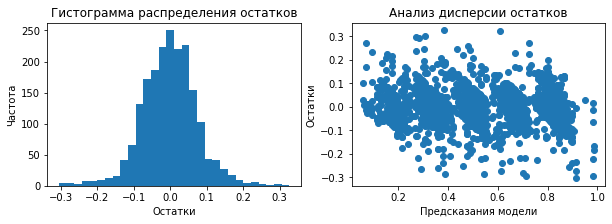

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
axes[0].hist(residuals, bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')

axes[1].scatter(x=y_pred, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии остатков')
plt.show()


На гистограмме большинство остатков расположены симметрично около нуля, но присутствуют длинные хвосты, на диаграмме рассеяния видим пять групп значений, исходя из наших знаний о данных, это может быть следствием влияния оценки от руководителя. В остальном, дисперсия постоянна на всех значениях предсказанных моделей.

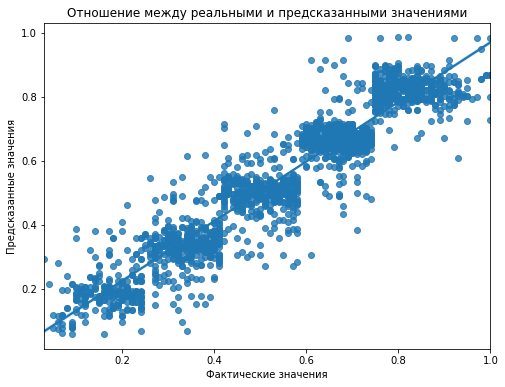

In [83]:
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test_job["job_satisfaction_rate"], y=y_pred)
plt.ylabel('Предсказанные значения')
plt.xlabel('Фактические значения')
plt.title('Отношение между реальными и предсказанными значениями')
plt.show()

На графике зависимости предсказанных значений от фактических снова наблюдаем 5 групп, точки имеют небольшой разброс возле прямой, но большинство из них находятся близко к ней.


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


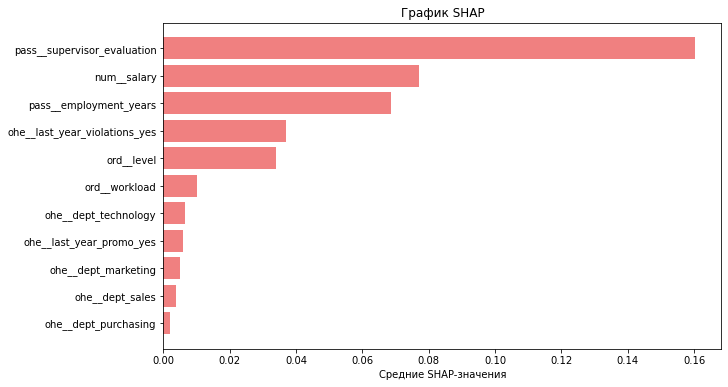

In [84]:
X_train_job_new = pipe_final.named_steps['preprocessor'].fit_transform(X_train_job)
X_test_job_new = pipe_final.named_steps['preprocessor'].transform(X_test_job)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.TreeExplainer(best_model.named_steps['models'])

shap_values = explainer.shap_values(X_test_job_new)

shap_mean = np.abs(shap_values).mean(axis=0)

plt.figure(figsize=(10, 6))
plt.barh(range(len(shap_mean.argsort())), shap_mean[shap_mean.argsort()], color='lightcoral')
plt.yticks(range(len(shap_mean.argsort())), np.array(feature_names)[shap_mean.argsort()])
plt.xlabel('Средние SHAP-значения')
plt.title('График SHAP')
plt.show()

Согласно SHAP-значениям, наибольший вклад в предсказания модели привносит оценка руководителя, слабее выражен эффект признаков "salary", "employment_years", "last_year_violations" и "level". Наименования отделов имеют слабое влияние на работу модели.

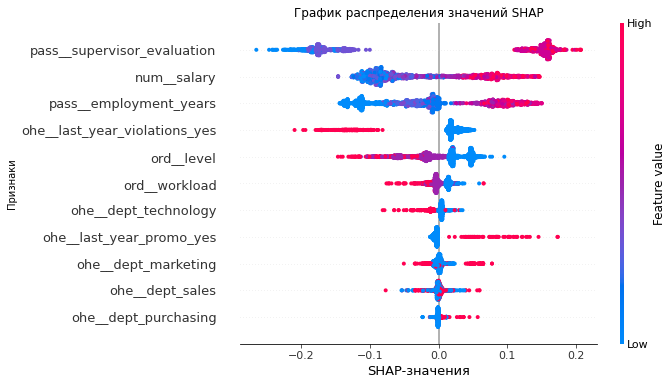

In [85]:
X_test_new_df = pd.DataFrame(X_test_job_new, columns=feature_names)

shap_values = explainer(X_test_new_df)

fig, ax = plt.subplots()
shap.plots.beeswarm(shap_values, max_display=11, show=False)
ax.set_xlabel('SHAP-значения')
ax.set_ylabel('Признаки')
ax.set_title('График распределения значений SHAP')
plt.show()

Чем выше оценка руководителя, тем большее значение SHAP value назначается этому признаку, высокие значения трудового стажа в компании и зарплата также имеют большое значение при определении уровня удовлетворенности, как и отсутствие нарушений трудового договора в прошлом. Чем ниже должность в компании, тем влияние на целевой признак выше. Высокое влияние на признак также оказывает получение повышения в прошлом году. 

**Вывод:** В результате подбора гиперпараметров с помощью RandomizedSearchCV наилучшую метрику SMAPE на кросс-валидации дала модель регрессии, основанная на алгоритме дерева решений, где каждый узел представляет собой проверку определенного признака, а каждый лист дерева представляет собой конечное предсказание. На тестовой выборке мы получили результат 13,67, это означает, что в среднем наши предсказанные значения отклоняются от фактических на 13,67%. Выявлено сильное влияние признака "supervisor_evaluation" на предсказания, на графиках распределения остатков и регресии, где значения распределяются на группы по значению оценки от руководителя. Гораздо меньшее влияние оказывает отдел и уровень загрузки.

### Вывод ##

По результатам определения лучшей модели и аналтза влияния признаков на предсказания сделать следующие выводы:

1. Выбор модели:

Модель DecisionTreeRegressor с глубиной 19 и минимальным количеством образцов в узле 6 и в листе 2 показала лучшие результаты по метрике SMAPE. Это указывает на то, что данная модель лучше всего справляется с задачей предсказания целевой переменной.

2. Избежание переобучения:

На тестовых данных метрика SMAPE оказалась меньше, чем на тренировочных, что указывает на то, что удалось избежать переобучения модели. Это важный аспект, который свидетельствует о том, что модель обладает хорошей обобщающей способностью.

3. Преимущества DecisionTreeRegressor перед линейной регрессией:

Факт того, что все модели с лучшей метрикой являются DecisionTreeRegressor, может свидетельствовать о наличии сложных нелинейных связей в данных, с которыми линейная регрессия не справляется.
Деревья решений обладают более гибкой структурой, что позволяет им лучше адаптироваться к сложным взаимосвязям в данных.

4. Влияние признаков на предсказания модели:

SHAP-значения позволили выявить, что наибольший вклад в предсказания модели привносит оценка руководителя, что является ключевым фактором.
Признаки "salary", "employment_years" и "last_year_violations" также оказывают влияние на предсказания модели, хотя и в меньшей степени.
Наименования отделов имеют слабое влияние на предсказания модели.

5. Анализ остатков:

Ненормальное распределение остатков, выявленное на графике q-q plot, подтверждает, что метрика SMAPE лучше подходит для оценки точности модели, чем коэффициент детерминации.
Наличие пяти групп значений на диаграмме рассеяния может быть следствием влияния оценки от руководителя и сложной структуры данных.

## Задание: предсказание увольнения сотрудника из компании ##

На этом этапе нам необходимо построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Загрузка данных ###

Загрузим датасет с тренировочной выборкой.

In [86]:
train_quit = pd.read_csv('/datasets/train_quit.csv')

In [87]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [88]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


В тренировочной выборке содержится 9 признаков + 1 целевой и 4000 строк. Признаки те же, что мы использовали для построения модели предсказания оценки удовлетворенности сотрудников, и добавлена информация об увольнении сотрудника.

В качестве входных признаков для тестовой выборки мы используем уже имеющийся датасет.

In [89]:
X_test_quit = X_test_job

In [90]:
X_test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [91]:
X_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 205.2+ KB


Загрузим целевой признак тестовой выборки.

In [92]:
y_test_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [93]:
y_test_quit.head(5)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [94]:
y_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Теперь нам необходимо отсортировать этот датасет по id, переназначить индексы и оставить только те номера, которые содержатся в датасете X_test_quit.

In [95]:
y_test_quit = y_test_quit.sort_values(by='id').set_index('id')

In [96]:
y_test_quit = y_test_quit[y_test_quit.index.isin(X_test_quit.index)]

In [97]:
y_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


In [98]:
if X_test_job.index.equals(y_test_job.index):
    print('Индексы одинаковые.')
else:
    print('Индексы разные.')

Индексы одинаковые.


**Вывод:** Мы загрузили файлы с информацией об увольнениях и предварительно ознакомились их составом, целевой признак тестовой выборки приведен в соответствие с имеющимися входными признаками: цизменены количество и порядок строк.

### Предобработка данных ###

Согласно общей информации тренировочные данные не содержат пропуски. Проведем проверку на дубликаты, для этого приведем все значения к одинаковому регистру, зададим новые индексы и рассмотрим уникальные значения по столбцам.

In [99]:
train_quit = lowercase_strings(train_quit)
train_quit = train_quit.set_index('id')
show_unique(train_quit)

Уникальные значения в dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в level: ['middle' 'junior' 'sinior']
Уникальные значения в workload: ['high' 'medium' 'low']
Уникальные значения в last_year_promo: ['no' 'yes']
Уникальные значения в last_year_violations: ['no' 'yes']
Уникальные значения в quit: ['no' 'yes']


Снова изменим 'sinior' на 'senior'.

In [100]:
train_quit['level'] = train_quit['level'].apply(lambda x: 'senior' if x == 'sinior' else x )

In [101]:
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

Теперь займемся поиском дубликатов.

In [102]:
train_quit.duplicated().sum()

1413

Удалим эти строки.

In [103]:
train_quit = train_quit.drop_duplicates()

In [104]:
train_quit.shape

(2587, 9)

После удаления дубликатов осталось 2587 строк.

In [105]:
train_quit.nunique()

dept                      5
level                     3
workload                  3
employment_years         10
last_year_promo           2
last_year_violations      2
supervisor_evaluation     5
salary                   69
quit                      2
dtype: int64

Количество уникальных значений совпадает с тем, что мы наблюдали в предыдущей задаче. Целевой признак является бинарным. Посмотрим на соотношение объемов тренировочной и тестовой выборок.

In [106]:
print(f"Соотношение размера тренировочной и тестовой выборки: тренировочная {train_quit.shape[0]/(train_quit.shape[0]+X_test_quit.shape[0])*100:.2f}%, тестовая {X_test_quit.shape[0]/(train_quit.shape[0]+X_test_quit.shape[0])*100:.2f}%")

Соотношение размера тренировочной и тестовой выборки: тренировочная 56.40%, тестовая 43.60%


Соотношение данных для обучения и тестирования несбалансированное, но в условиях использования кросс-валидации приемлемое.

В имеющиеся данные добавим прогнозные значения оценки удовлетворенности сотрудников, подготовленные с помощью модели.

In [107]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit.drop('quit', axis=1))

In [108]:
X_test_quit['job_satisfaction_rate'] = best_model.predict(X_test_quit)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Вывод:** На этом этапе мы избавились от дубликатов в тренировочных данных, рассмотрели уникальные значения, определили соотношение тестовой и тренировочной выборок и добавили в исследование новый признак - предсказанную оценку удовлетворенности сотрудников.

### Исследовательский анализ ###

Изучим тренировочные данные, разделив их на группы по целевому признаку. Для начала посмотрим баланс значений в тестовой и тренировочной выборках.

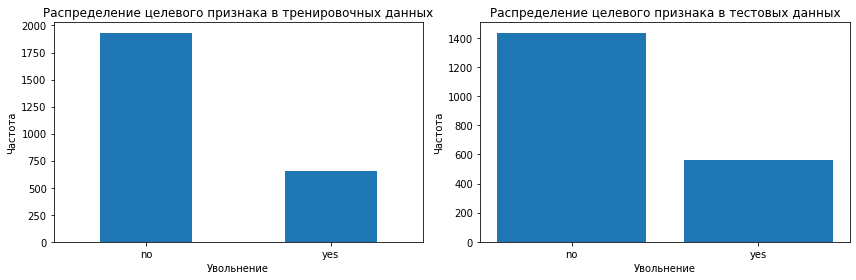

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train_quit['quit'].value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title('Распределение целевого признака в тренировочных данных')
ax[0].set_xlabel('Увольнение')
ax[0].set_ylabel('Частота')

unique_values_train, counts_train = np.unique(y_test_quit, return_counts=True)
ax[1].bar(unique_values_train, counts_train)
ax[1].set_title('Распределение целевого признака в тестовых данных')
ax[1].set_xlabel('Увольнение')
ax[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Баланс класов соблюден. Теперь можно перейти к исследованию признаков тренировочной выборки.

In [110]:
train_quit.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2587.000000,2587.000000,2587.000000,2587.000000
mean,4.213375,3.367994,37107.692308,0.516495
std,2.601105,1.080243,16267.354906,0.221438
min,1.000000,1.000000,12000.000000,0.060000
25%,2.000000,3.000000,24000.000000,0.335000
50%,4.000000,3.000000,33600.000000,0.515000
75%,6.000000,4.000000,46800.000000,0.686667
max,10.000000,5.000000,96000.000000,0.985000


В нашем датасете только два непрерывных количественных признака - 'salary' и 'job_satisfaction_rate', для них мы построим гистограммы, но выборки по целевому признаку имеют разный размер, будет лучше представить данные в долевом соотношении.

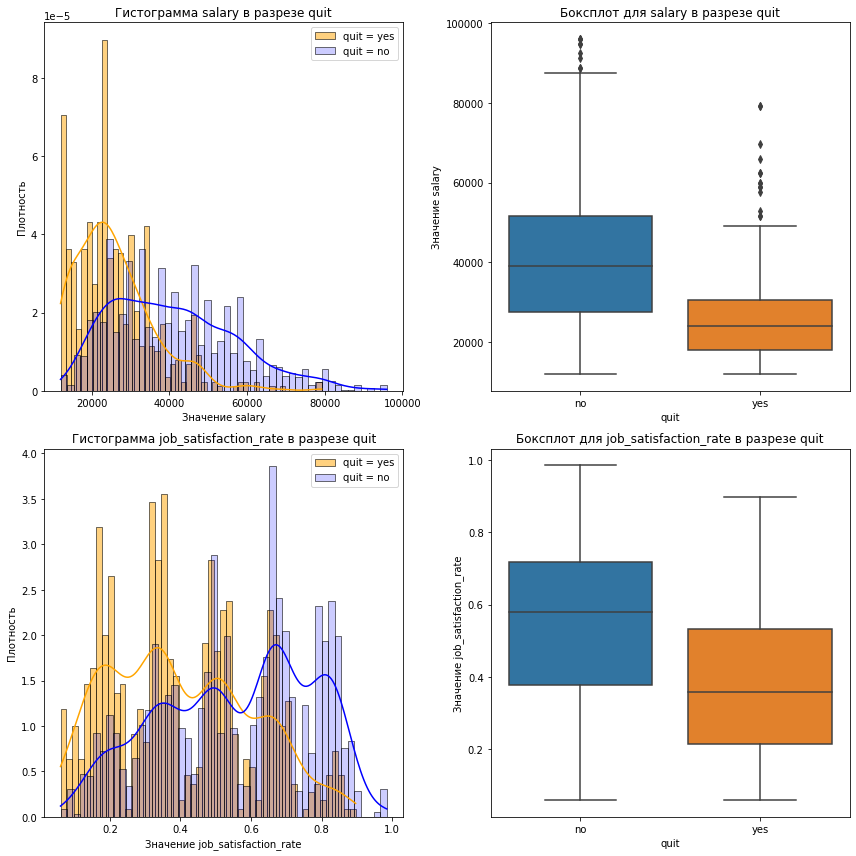

In [111]:
continuous_columns = ['salary', 'job_satisfaction_rate']

fig, axs = plt.subplots(len(continuous_columns), 2, figsize=(12, len(continuous_columns) * 6))
for i, col in enumerate(continuous_columns):
    
    sns.histplot(train_quit.query('quit == "yes"')[col], 
                 bins=50, ax=axs[i, 0], kde=True, color='orange', label='quit = yes', stat='density')
    sns.histplot(train_quit.query('quit == "no"')[col], 
                 bins=50, ax=axs[i, 0], kde=True, color='blue', label='quit = no', alpha=0.2, stat='density')
    axs[i, 0].set_title(f'Гистограмма {col} в разрезе quit')
    axs[i, 0].set_xlabel(f'Значение {col}')
    axs[i, 0].set_ylabel('Плотность')
    axs[i, 0].legend()

    sns.boxplot(data=train_quit, x='quit', y=col, ax=axs[i, 1])
    axs[i, 1].set_title(f'Боксплот для {col} в разрезе quit')
    axs[i, 1].set_xlabel('quit')
    axs[i, 1].set_ylabel(f'Значение {col}')

plt.tight_layout()
plt.show()

Среди тех, кто принял решение уволиться, медианная зарплата была почти в два раза ниже, чем в группе оставшихся, большинство значений сгруппировано в диапазоне до 40 тысяч, в их группе также чаще встречаются неудовлетворительные оценки, 75% оценок не превышают 0,5, тогда как для группы оставшихся эта граница фиксируется на 0,7. На гистограмме снова наблюдаем 5 групп значений, можно предположить, что такой результат стал следствием сильной корреляции 'job_satisfaction_rate' и 'supervisor_evaluation'. 

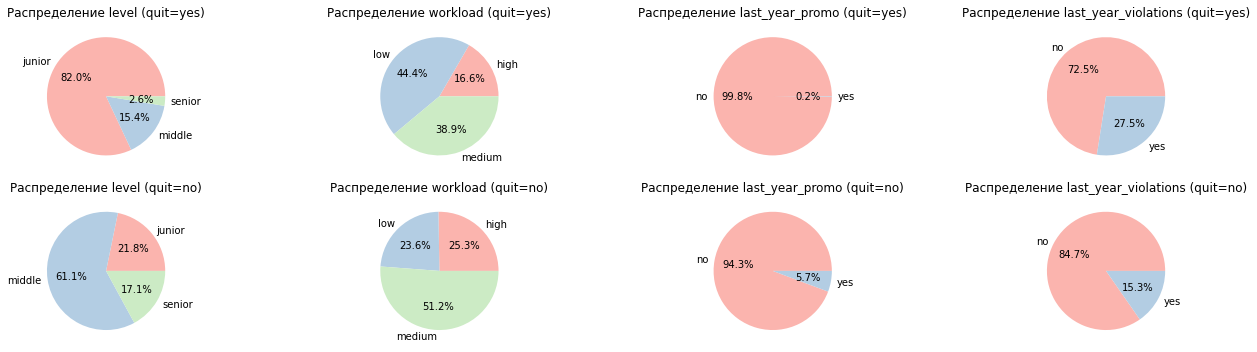

In [112]:
category_columns = ['level', 'workload','last_year_promo', 'last_year_violations']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 5))
for i, col in enumerate(category_columns):
    train_quit.query('quit == "yes"')[col].value_counts().sort_index().plot(
        kind='pie', autopct='%1.1f%%', ax=axes[0, i], colors=sns.color_palette('Pastel1')
    )
    train_quit.query('quit == "no"')[col].value_counts().sort_index().plot(
        kind='pie', autopct='%1.1f%%', ax=axes[1, i], colors=sns.color_palette('Pastel1')
    )
    axes[0, i].set_title(f'Распределение {col} (quit=yes)')
    axes[0, i].set_ylabel('')
    axes[1, i].set_title(f'Распределение {col} (quit=no)')
    axes[1, i].set_ylabel('')
plt.tight_layout()
plt.show()

Часто увольняются джуниоры: среди оставшихся сотрудников их всего 22%, тогда как принимают решение об увольнении 82%. Возможно, это связано с тем, что люди после определенного времени рассчитывают на повышение до уровня middle, но компания не предоставляет им такой возможности, или же в компании условия для стажировки гораздо выгоднее, чем постоянная работа, начинающие работники пользуются этим, чтобы накопить необходимый опыт и перейти работать в другое место.

Большинство, а именно 61% сотрудников, продолжающих работать в компании имеют уровень middle, среди оставивших работу их всего 15,4%. Совсем не склонны к увольнениям сениоры - среди ушедших их доля очень низкая, всего 2,6%. 
Низкая рабочая загрузка связана с увольнением - 44,4% уволившихся не были нагружены достаточно, и всего 16,6% работали в режиме сильной загруженнности. Эти показатели отличаются от того, что мы наблюдаем в выборке сотрудников, которые остались в компании: среди них доля слабой нагруженности 23,6%, больше половины работают в режиме умеренной загрузки.

Среди уволившихся очень низкий процент тех, кто получил повышение в прошлом году - 0,2%, а доля нарушивших трудовой договор больше, чем среди тех, кто остался - 27,5% против 15,3% у оставшихся.

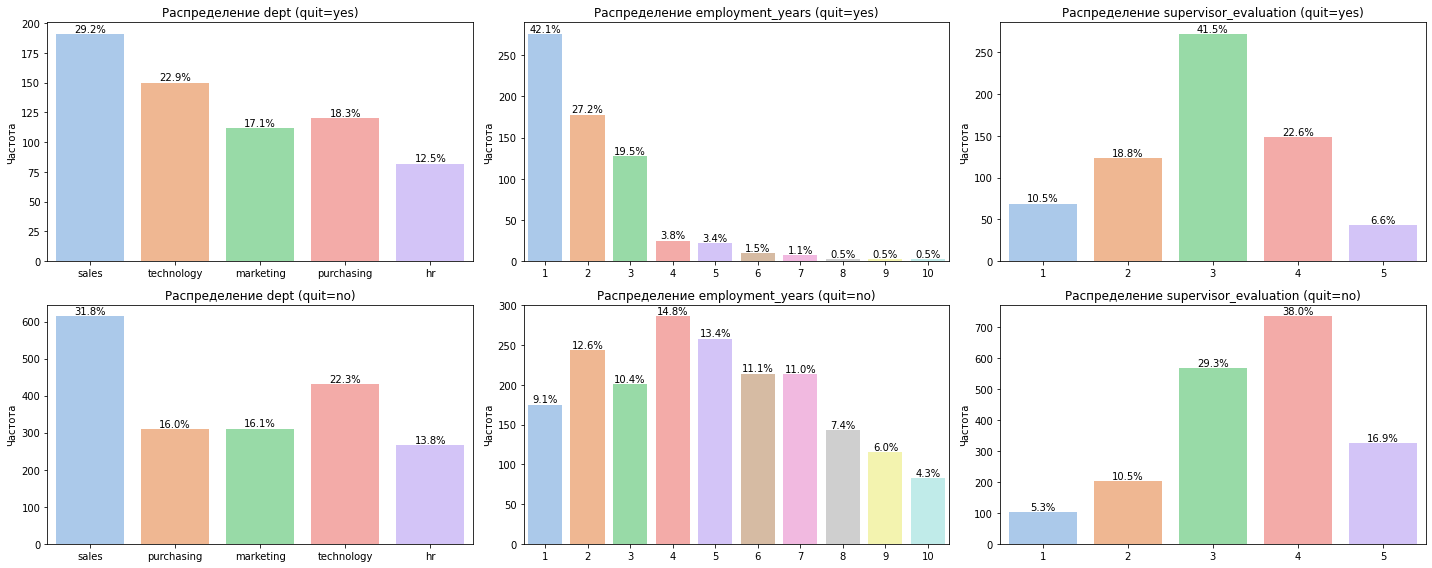

In [113]:
discrete_columns = ['dept', 'employment_years', 'supervisor_evaluation']
fig, axes = plt.subplots(nrows=2, ncols=len(discrete_columns), figsize=(20, 8))

for i, col in enumerate(discrete_columns):
    sns.countplot(data=train_quit[train_quit['quit'] == 'yes'], x=col, ax=axes[0, i], palette='pastel')
    axes[0, i].set_title(f'Распределение {col} (quit=yes)')
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('Частота')

    total_yes = len(train_quit[train_quit['quit'] == 'yes'][col])
    for p in axes[0, i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_yes)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[0, i].annotate(percentage, (x, y), ha='center', va='bottom')

    sns.countplot(data=train_quit[train_quit['quit'] == 'no'], x=col, ax=axes[1, i], palette='pastel')
    axes[1, i].set_title(f'Распределение {col} (quit=no)')
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('Частота')

    total_no = len(train_quit[train_quit['quit'] == 'no'][col])
    for p in axes[1, i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_no)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[1, i].annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Доля отдела закупок среди уволившихся больше, а доля отдела продаж немного меньше. 42% уволившихся сотрудников покидают компанию после 1 года работы, после 2 - 27% а после третьего - 19,5%, получается, что почти 90% работников, которые увольняются, принимают решение об этом в первые три года работы. 

Среди тех, кто остается в компании, больше человек получают хорошие оценки от руководителя: среди них доля оценок 4 и 5  значительно превышает показатели уволившихся. Низкие оценки больше характерны для тех, кто оставил компанию.

Рассмотрим те же графики для тестовых данных.

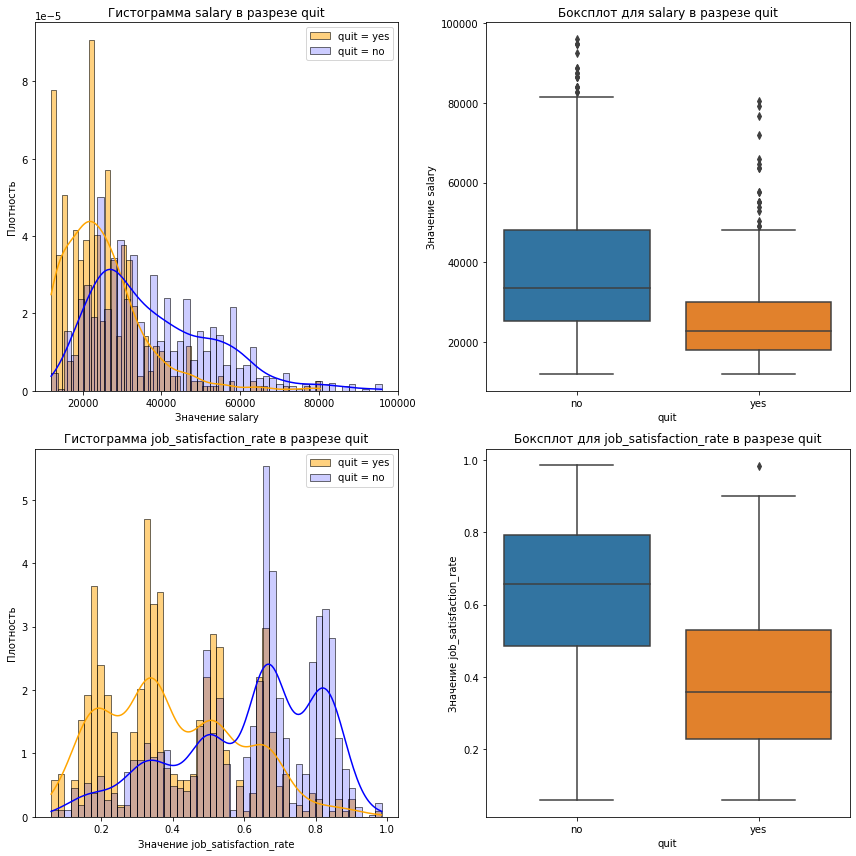

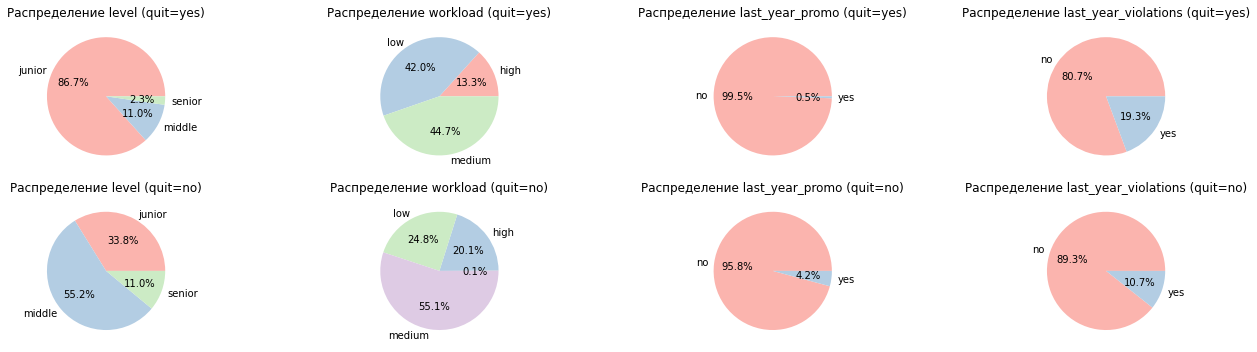

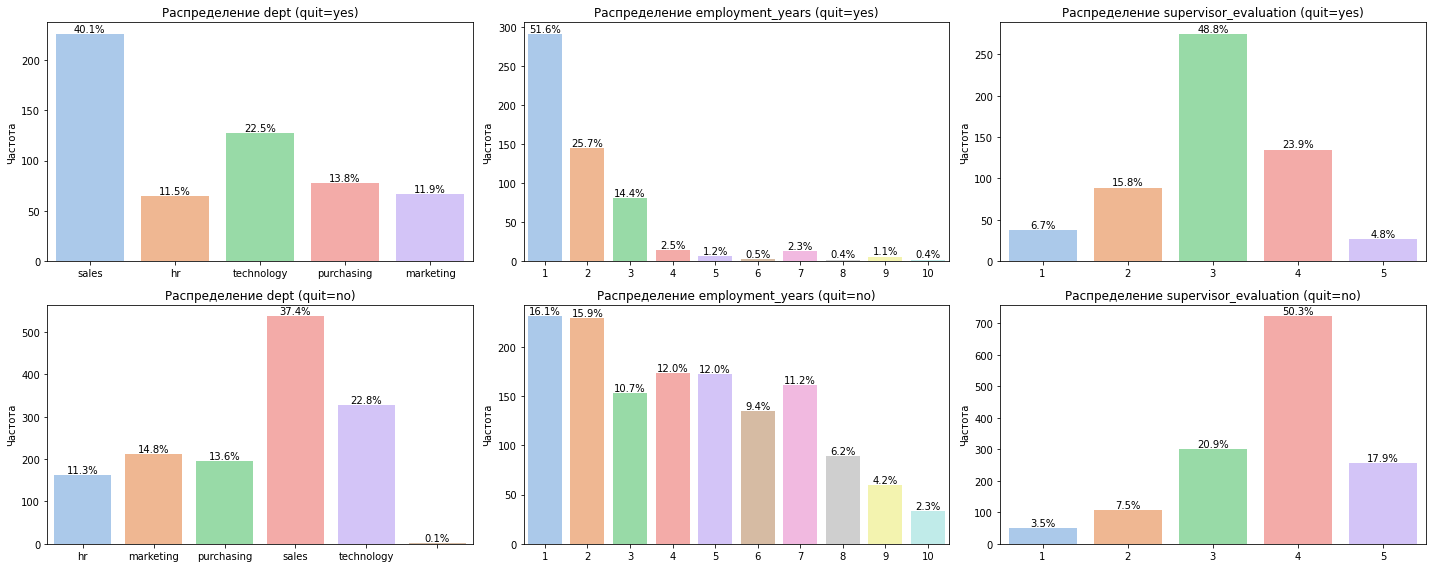

In [114]:
X_test_quit['quit'] = y_test_quit
fig, axs = plt.subplots(len(continuous_columns), 2, figsize=(12, len(continuous_columns) * 6))
for i, col in enumerate(continuous_columns):
    
    sns.histplot(X_test_quit.query('quit == "yes"')[col], bins=50, ax=axs[i, 0], 
                 kde=True, color='orange', label='quit = yes', stat='density')
    sns.histplot(X_test_quit.query('quit == "no"')[col], bins=50, ax=axs[i, 0], 
                 kde=True, color='blue', label='quit = no', alpha=0.2, stat='density')
    axs[i, 0].set_title(f'Гистограмма {col} в разрезе quit')
    axs[i, 0].set_xlabel(f'Значение {col}')
    axs[i, 0].set_ylabel('Плотность')
    axs[i, 0].legend()

    sns.boxplot(data=X_test_quit, x='quit', y=col, ax=axs[i, 1])
    axs[i, 1].set_title(f'Боксплот для {col} в разрезе quit')
    axs[i, 1].set_xlabel('quit')
    axs[i, 1].set_ylabel(f'Значение {col}')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 5))
for i, col in enumerate(category_columns):
    X_test_quit.query('quit == "yes"')[col].value_counts().sort_index().plot(
        kind='pie', autopct='%1.1f%%', ax=axes[0, i], colors=sns.color_palette('Pastel1')
    )
    X_test_quit.query('quit == "no"')[col].value_counts().sort_index().plot(
        kind='pie', autopct='%1.1f%%', ax=axes[1, i], colors=sns.color_palette('Pastel1')
    )
    axes[0, i].set_title(f'Распределение {col} (quit=yes)')
    axes[0, i].set_ylabel('')
    axes[1, i].set_title(f'Распределение {col} (quit=no)')
    axes[1, i].set_ylabel('')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=len(discrete_columns), figsize=(20, 8))

for i, col in enumerate(discrete_columns):
    sns.countplot(data=X_test_quit[X_test_quit['quit'] == 'yes'], x=col, ax=axes[0, i], palette='pastel')
    axes[0, i].set_title(f'Распределение {col} (quit=yes)')
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('Частота')

    total_yes = len(X_test_quit[X_test_quit['quit'] == 'yes'][col])
    for p in axes[0, i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_yes)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[0, i].annotate(percentage, (x, y), ha='center', va='bottom')

    sns.countplot(data=X_test_quit[X_test_quit['quit'] == 'no'], x=col, ax=axes[1, i], palette='pastel')
    axes[1, i].set_title(f'Распределение {col} (quit=no)')
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('Частота')

    total_no = len(X_test_quit[X_test_quit['quit'] == 'no'][col])
    for p in axes[1, i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_no)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[1, i].annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Распределения тестовой выборки почти идентичны распределениям признаков в тренировочных данных с поправкой на разное количество записей. Так, например, среди тех кто принял решение об увольнении, в тестовых данных появляется запись о сотруднике, который очень высоко оценивает удовлетворенность своей работой, распределение оставшихся в компании работников по годам стажа до 8 лет в тестовой выборке более равномерное, а доля сотрудников, получивших оценку 3 меньше.

Посмотрим на корреляцию признаков в тренировочных данных. Построим матрицу Phik сначала для всего набора данных, а затем изучим корреляцию по группам целевого признака.

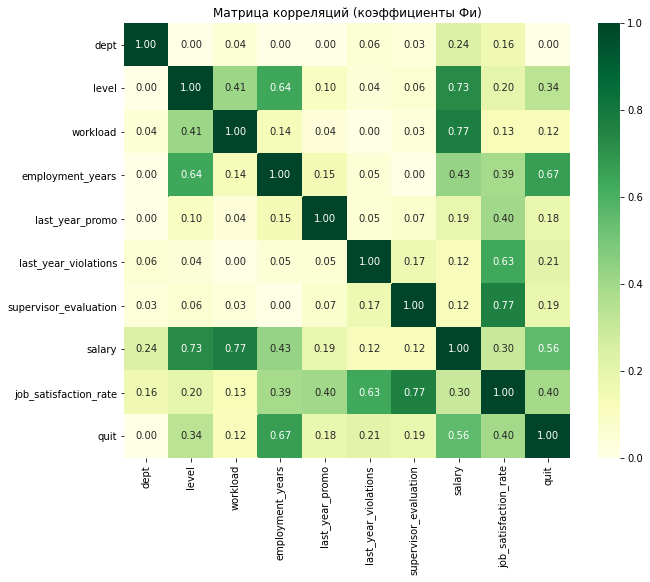

In [115]:
train_quit = train_quit[
    ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
    'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate', 'quit']
]
plt.figure(figsize=(10, 8))
sns.heatmap(train_quit.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.2f', cmap='YlGn')
plt.title('Матрица корреляций (коэффициенты Фи)', fontdict={'fontsize': 12})
plt.show()

Сильную взаимосвязь с целевым признаком имеют 'employment_years' и 'salary'. По-прежнему наблюдаем высокую корреляцию признаков 'job_satisfaction_rate' и 'supervisor_evaluation', 'salary' и 'workload', 'salary' и 'level'.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


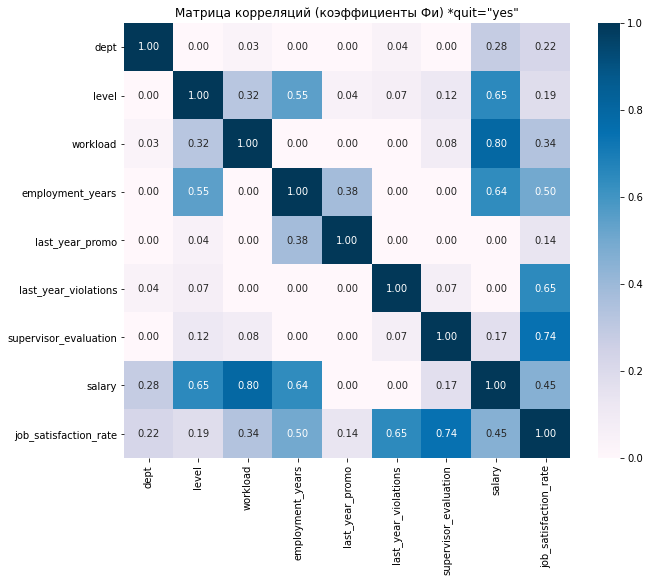

In [116]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_quit.query('quit == "yes"').phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.2f', cmap='PuBu')
plt.title('Матрица корреляций (коэффициенты Фи) *quit="yes"', fontdict={'fontsize': 12})
plt.show()

Корреляция некоторых признаков в основном ослабла или осталась на прежнем уровне в наборе данных с уволившимися сотрудниками. Усилилась связь некоторых признаков с 'salary'.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


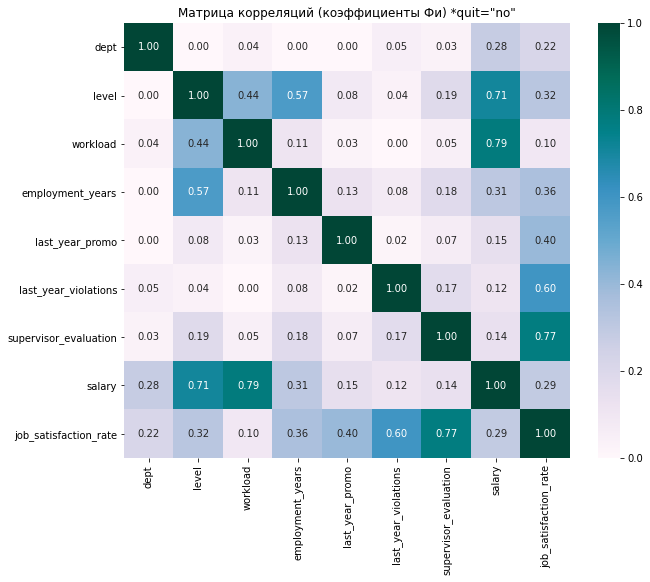

In [117]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_quit.query('quit == "no"').phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.2f', cmap='PuBuGn')
plt.title('Матрица корреляций (коэффициенты Фи) *quit="no"', fontdict={'fontsize': 12})
plt.show()

Анализ выборки с сотрудниками, которые остались в компании, не показал таких драматических изменений, взаимная связь или такая же, или немного уменьшилась. Связь признаков 'job_satisfaction_rate' и 'supervisor_evaluation', 'workload' и 'salary' остается сильной во всех случаях.

**Вывод:** 

Благодаря исследовательском анализу данных, мы можем сделать выводы о типичном уволившемся сотруднике. С большой долей уверенности можно сказать, что он:
- получает зарплату до 30000;
- ставит оценку удовлетворенности своей работой в диапазоне от 0,2 до 0,5;
- занимает должность уровня junior, но очень хочет повышения;
- на работе загружен слабо или умеренно;
- возможно, нарушал трудовую дисциплину;
- работает в отделе продаж, технологий или закупок - об этом сложно сделать вывод;
- стаж работы на текущем месте не превышает 3 лет;
- руководитель, оценивая качество его работы, ставит оценку ниже 3.

При исследовании корреляции признаков мы обнаружили, что с целевым признаком 'quit' сильную связь имеют признаки 'employment_years' и 'salary'.  Также мы столкнулись с возможной мультиколлинеарностью признаков 'salary' и 'workload', степень которой возрастает в данных с уволившимися сотрудниками, а также 'job_satisfaction_rate' и 'supervisor_evaluation', признак 'dept', согласно таблице коэффициентов корреляции, не имеет прямой взаимосвязи с целейвым признаком.

### Обучение модели ###

Подготовим данные:

In [118]:
X_train_quit = train_quit.drop('quit', axis=1)
y_train_quit = train_quit['quit']
X_test_quit = X_test_quit.drop('quit', axis=1)
y_test_quit = y_test_quit['quit']

Теперь с помощью LabelEncoder закодируем целевой признак.

In [119]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train_quit)

y_train = label_encoder.transform(y_train_quit)
y_test = label_encoder.transform(y_test_quit) 

Создадим списки столбцов для кодирования и масштабирования, для начала используем весь набор признаков. 

In [120]:
cols_ohe_2 = ['dept', 'last_year_promo', 'last_year_violations']
cols_ord_2 = ['level', 'workload']
cols_num_2 = ['salary', 'job_satisfaction_rate']
cols_pass_2 = ['supervisor_evaluation', 'employment_years']

Специфика данных не изменилась, поэтому возьмем пайплланы для подготовки из предыдущего моделирования, но общий пайплайн создадим новый.

In [121]:
preprocessing_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cols_ohe_2),
        ('ord', ord_pipe, cols_ord_2),
        ('num', StandardScaler(), cols_num_2),
        ('pass', 'passthrough', cols_pass_2)
    ], 
    remainder='passthrough'
) 
pipe_final_2 = Pipeline(
    [
        ('preprocessor', preprocessing_2),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Создадим сетку гиперпараметров и с помощью случайного поиска RandomizedSearchCV подберем оптимальные параметры модели в пайплайне с препроцессором данных. Количество разбиений для кросс-валидации сделаем равным пяти, потому что у нас достаточно мало данных, и это поможет сделать оценку качества модели точнее. Проведем 200 итераций для более точного определения параметров лучшей модели. Выбор будем производить по лучшей метрике между моделями DecisionTreeClassifier(), KNeighborsClassifier(), и LogisticRegression().

Перед нами стоит задача классификации, а наш целевой признак - бинарный и несбалансированный, для определения качества модели будем использовать метрику ROC-AUС. Это обобщенная мера производительности модели, которая учитывает ее способность правильно определять как положительные, так и отрицательные объекты. Чем ближе метрика будет к 1, тем лучше. По условиям задачи она не должна быть меньше 0,91 на тестовой выборке.

In [122]:
param_grid_2 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,13),
        'models__min_samples_split':range(2, 13),
        'models__min_samples_leaf': range(2,9), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3,17),
        'models__metric': ['euclidean', 'manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler()]  
    }
    
]
    
random_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=200
)
random_search_2.fit(X_train_quit, y_train) 
print('Лучшая модель и её параметры:\n\n', random_search_2.best_estimator_)
print ('Метрика лучшей модели по кросс-валидации', random_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Метрика ROC-AUC на кросс-валидации для этой модели составляет 0.9065, что указывает на хорошее качество модели в среднем по всем 5 фолдам кросс-валидации. В качестве лучшей модели классификатора используется KNeighborsClassifier с параметром "манхэттенское расстояние" для вычисления расстояния между точками в пространстве признаков, число соседей для принятия решения о присвоении класса 16. Количественные признаки масштабируются с помощью MinMaxScaler. Посмотрим, какие еще модели дали хороший результат.

In [123]:
result_2 = pd.DataFrame(random_search_2.cv_results_) 
result_2.sort_values('rank_test_score')[['rank_test_score', 'param_models', 'mean_test_score','params']].head(15)

,rank_test_score,param_models,mean_test_score,params
157,1,KNeighborsClassifier(),0.906457,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 16, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"
80,2,KNeighborsClassifier(),0.903985,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 16, 'models__metric': 'euclidean', 'models': KNeighborsClassifier()}"
102,3,KNeighborsClassifier(),0.903560,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 15, 'models__metric': 'euclidean', 'models': KNeighborsClassifier()}"
8,4,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.903206,"{'preprocessor__num': RobustScaler(), 'models__C': 2, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
133,5,DecisionTreeClassifier(random_state=42),0.903161,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 2, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
166,5,DecisionTreeClassifier(random_state=42),0.903161,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
9,5,DecisionTreeClassifier(random_state=42),0.903161,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
165,8,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.902968,"{'preprocessor__num': RobustScaler(), 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
135,9,DecisionTreeClassifier(random_state=42),0.902932,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 2, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
108,10,DecisionTreeClassifier(random_state=42),0.902849,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 11, 'models__min_samples_leaf': 2, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"


Классификаторы метода k-ближайших соседей дают наилучшие результаты, но все три рассматриваемые модели оказались в списке 15 лучших. Успех KNeighborsClassifier может быть связан с тем, что в данных есть сложные нелинейные зависимости, которые хорошо описываются соседними объектами в пространстве признаков.

In [124]:
total_combinations_2 = 1
for params in param_grid_2:
    values_count = [len(value) for value in params.values()]
    total_combinations_2 *= sum(values_count)
print('Общее количество комбинаций:', total_combinations_2)

Общее количество комбинаций: 5120


Чтобы попробовать достичь лучшего результата в правильном определении увольняющихся сотрудников с помощью модели, попробуем избавиться от мультиколлинеарности признаков, удалив 'supervisor_evaluation', а также удалим признак 'dept' из-за его слабой связи с целевым признаком.

In [125]:
cols_ohe_3 = ['last_year_promo', 'last_year_violations']
cols_ord_3 = ['level', 'workload']
cols_num_3 = ['salary', 'job_satisfaction_rate']
cols_pass_3 = ['employment_years']

X_train_quit_2 = train_quit.drop(columns=['quit', 'dept', 'supervisor_evaluation'], axis=1)
X_test_quit_2 = X_test_quit.drop(columns=['dept', 'supervisor_evaluation'], axis=1)


preprocessing_3 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cols_ohe_3),
        ('ord', ord_pipe, cols_ord_3),
        ('num', StandardScaler(), cols_num_3),
        ('pass', 'passthrough', cols_pass_3)
    ], 
    remainder='passthrough'
) 
pipe_final_3 = Pipeline(
    [
        ('preprocessor', preprocessing_3),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)
param_grid_3 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,13),
        'models__min_samples_leaf': range(2,9), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3,17),
        'models__metric': ['euclidean', 'manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler()]  
    }
    
]
    
random_search_3 = RandomizedSearchCV(
    pipe_final_3, 
    param_grid_3, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=200
)
random_search_3.fit(X_train_quit_2, y_train) 
print('Лучшая модель и её параметры:\n\n', random_search_3.best_estimator_)
print ('Метрика лучшей модели по кросс-валидации', random_search_3.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                    

Метрика кросс-валидации 0,91 показывает, что модель лучше справляется с задачей классификации на тренировочных данных, из которых мы удалили два признака. В качестве лучшей модели классификатора используется KNeighborsClassifier. В модели применяется метод манхэттенского расстояния (metric='manhattan') для измерения расстояния между соседями. Оптимальное количество соседей равно 14 (n_neighbors=14). Количественные признаки масштабируются с помощью StandardScaler(). Выведем модели с лучшими разультатами на метрике.

In [126]:
result_3 = pd.DataFrame(random_search_3.cv_results_) 
result_3.sort_values('rank_test_score')[['rank_test_score', 'param_models', 'mean_test_score','params']].head(15)

,rank_test_score,param_models,mean_test_score,params
45,1,KNeighborsClassifier(),0.910167,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 14, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"
64,2,KNeighborsClassifier(),0.909478,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 13, 'models__metric': 'euclidean', 'models': KNeighborsClassifier()}"
140,3,KNeighborsClassifier(),0.908831,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 16, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"
34,4,KNeighborsClassifier(),0.908639,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 13, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"
29,5,KNeighborsClassifier(),0.908434,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 15, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"
181,6,KNeighborsClassifier(),0.906464,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 11, 'models__metric': 'euclidean', 'models': KNeighborsClassifier()}"
144,7,KNeighborsClassifier(),0.906442,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 10, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"
55,8,KNeighborsClassifier(),0.905926,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 9, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"
153,9,KNeighborsClassifier(),0.905792,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 14, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"
141,10,KNeighborsClassifier(),0.905725,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 16, 'models__metric': 'manhattan', 'models': KNeighborsClassifier()}"


На полном наборе признаков ни одна модель не показала результат выше 0,906, но при исключении избыточных признаков, 5 моделей показали результат лучше. С уверенностью можно сказать, что удаление признаков 'dept' и 'supervisor_evaluation' помогло улучшить метрику по результатам кросс-валидации на тренировочных данных. Но в списке лучших моделей больше нет логистической регрессии, она чувствительна к сложным взаимосвязям признаков. Посмотрим на метрику на тестовой выборке.

In [127]:
best_model_2 = random_search_3.best_estimator_
y_test_proba_2 = best_model_2.predict_proba(X_test_quit_2)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba_2)}')

Метрика ROC-AUC на тестовой выборке: 0.924303374227069


Метрика ROC-AUC на тестовых данных 0.9243 - это соответствует условиям задачи. Значение метрики на тестовых данных выше, чем на кросс-валидации тренировочных данных.

Поробуем рассчитать метрику ROC-AUC с помощью базовой модели DummyClassifier с параметром strategy='stratified', который означает, что классификатор будет предсказывать вероятности классов, пропорциональные их распределению в обучающей выборке. Низкое значение метрики поможет нам определить,насколько хорошо наша лучшая модель способна извлекать полезные зависимости из данных.

In [128]:
dummy_class = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_class.fit(X_train_quit_2, y_train)

y_pred_dummy_class = dummy_class.predict_proba(X_test_quit_2)[:, 1]

print(f'Метрика ROC-AUC на тестовой выборке при использовании базовых предсказаний: {roc_auc_score(y_test, y_pred_dummy_class)}')

Метрика ROC-AUC на тестовой выборке при использовании базовых предсказаний: 0.501266816807918


Метрика ROC-AUC, DummyClassifier с вероятностной стратегией предсказания случайных вероятностей получает значение ROC-AUC, близкое к 0.5, что означает случайное угадывание классов.

С другой стороны, KNeighborsClassifier демонстрирует значительно лучшее качество предсказаний, так как значение ROC-AUC близко к 1. Это говорит о том, что классификатор хорошо разделяет классы и дает правильные предсказания.

Нас интересует правильное определение моделью сотрудников, которые хотят уволиться, поэтому стоит обратить внимание на метрику recall.

In [129]:
y_pred = best_model_2.predict(X_test_quit_2)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report)
report_df

,0,1,accuracy,macro avg,weighted avg
precision,0.927062,0.857411,0.9085,0.892236,0.907420
recall,0.947075,0.810284,0.9085,0.878679,0.908500
f1-score,0.936962,0.833181,0.9085,0.885072,0.907696
support,1436.000000,564.000000,0.9085,2000.000000,2000.000000


Сейчас метрика recall ниже precision, это может указывать на то, что модель модель чаще дает ложноотрицательные результаты, но реже ошибочно присваивает класс 1. Посмотрим на матрицу ошибок.

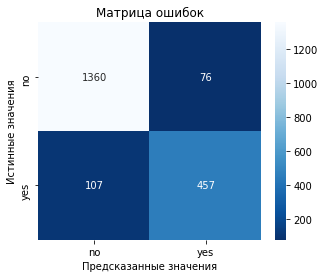

In [130]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

Модель правильно определила 457 случая увольнения из 564. 

Результат уже неплохой, мы можем подвинуть пороги вероятности присвоения класса, но тогда доля ложноположительных предсказаний сильно возрастет. 

Резюмируем наши выводы с помощью построения кривой ROC.

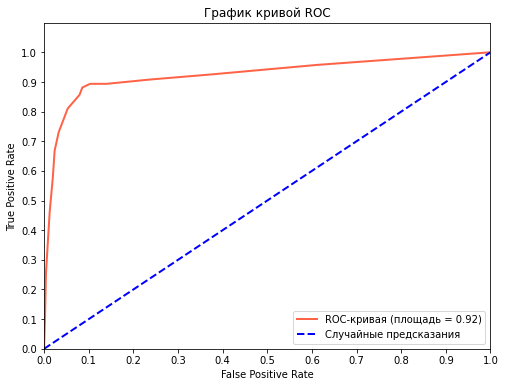

In [131]:
best_knn = best_model_2.named_steps['models']
fpr, tpr, _ = roc_curve(y_test, y_test_proba_2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='tomato', lw=2, label=f'ROC-кривая (площадь = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Случайные предсказания')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График кривой ROC')
plt.legend(loc="lower right")
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

Здесь мы видим насколько далеко кривая ROC находится на графике от случайных предсказаний - чем ближе кривая ROC к верхнему левому углу графика, тем лучше модель. Уже при доле ложно-положительных ответов 0,1 мы получим метрику recall близкую к значению 0,9, сейчас доля верно предсказанных положительных результатов из всех реальных положительных результатов 0,81.

Составим таблицу важности признаков для лучшей модели с помощью определения перестановочной важности, оценим важность метрикой ROC-AUC. 

In [132]:
pipe_final_3.named_steps['preprocessor'].fit(X_train_quit_2)
X_test_quit_new = pipe_final_3.named_steps['preprocessor'].transform(X_test_quit_2)
feature_names_2 = pipe_final_3.named_steps['preprocessor'].get_feature_names_out()
permut = permutation_importance(best_knn, X_test_quit_new, y_test, scoring = 'roc_auc') 

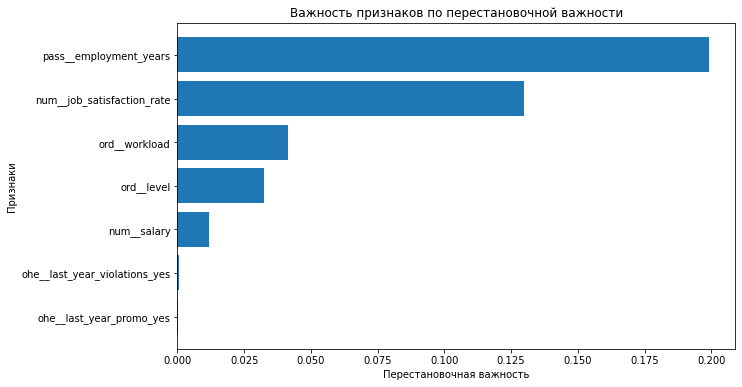

In [133]:
importances = permut.importances_mean

sorted_indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names_2[i] for i in sorted_indices])
plt.xlabel('Перестановочная важность')
plt.ylabel('Признаки')
plt.title('Важность признаков по перестановочной важности')
plt.show()

Наибольший вклад в прогноз оказывает количество отработанных лет, чуть менее влияют на предсказание оценка удовлетворенности сотрудника, загруженность, должность и зарплата. Перестановка значений в фактах повышения или нарушения трудового договора фактически не повлияли на способность модели к предсказанию.

**Вывод:** 
Выбор лучшей модели для предсказания увольнения сотрудников мы производили по лучшей метрике ROC-AUC на кросс-валидации между моделями DecisionTreeClassifier(), KNeighborsClassifier(), и LogisticRegression(). Сначала мы использовали полный набор признаков, алгоритм предобработки взяли из первой задачи (добавился только новый признак - предсказанные значения 'job_satisfaction_rate').

Лучшей моделью был выбран классификатор KNeighborsClassifier, с оптимальным количеством соседей 16, количественные признаки масштабируются с помощью MinMaxScaler. Слассификаторы метода k-ближайших соседей дают наилучшие результаты, но все три рассматриваемые модели оказались в списке 15 лучших. Успех KNeighborsClassifier может быть связан с тем, что в данных есть сложные нелинейные зависимости, которые хорошо описываются соседними объектами в пространстве признаков. 

Для более качественного определения уволившихся сотрудников было решено попробовать найти новую модель с отобранными признаками, так, мы удалили сильно коррелирующий с 'job_satisfaction_rate' признак 'supervisor_evaluation', как избыточный, а также признак 'dept' - при исследовательском анализе мы не установили тесной его связи с целевым признаком. С новыми данными лучшей моделью снова была выбрана снова KNeighborsClassifier. В модели применялся манхэттенский метод для измерения расстояния между соседями. Оптимальное количество соседей равно 14 (n_neighbors=14). Количественные признаки масштабировались с помощью StandardScaler. Топ лучших моделей по результатам определения метрики ROC-AUC на валидации состоял из KNeighborsClassifier и DecisionTreeClassifier. Можно сделать выводы о данных: KNeighborsClassifier хорошо подходит для задач, в которых объекты одного класса обычно находятся рядом в пространстве признаков. DecisionTreeClassifier, с другой стороны, может хорошо работать, если данные имеют сложную структуру или существуют нелинейные зависимости между признаками и целевой переменной. Скорее всего от нелинейности зависимости нам не удалось избавиться, но объекты классов стали ближе друг к другу. Лучшая модель обладает неплохим балансом между recall и precision, что означает, что она достаточно хорошо определяет увольняющихся сотрудников, метрика ROC-AUC на тестовых данных 0,92 соответствует поставленной задаче.

### Общий вывод ###

В процессе выполнения задания по построению модели для предсказания уровня удовлетворённости сотрудников и определения тех, кто может уволиться, мы применили различные методы и модели машинного обучения для достижения максимально точных прогнозов. 

Модель предсказания уровня удовлетворённости сотрудников:

Мы обучили две модели - линейную регрессию и дерево решений, и выбрали лучшую модель на основе метрики SMAPE.
Лучшей моделью для предсказания уровня удовлетворённости стала модель DecisionTreeRegressor с гиперпараметрами: max_depth=19, min_samples_leaf=2, min_samples_split=6.
Модель показала хорошие результаты как на тренировочных, так и на тестовых данных, и не наблюдается переобучение.
Наибольшее влияние на прогноз оказывают оценка руководителя, трудовой стаж и отсутствие нарушений трудового договора.

Модель предсказания увольнения сотрудников:

Мы обучили три модели - DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression, и выбрали лучшую модель на основе метрики ROC-AUC по результатам кросс-валидации. Мы рассмотрели два варианта исходных данных: полный набор признаков, включая предсказанные значения уровня удовлетворённости сотрудников, и набор без признака со слабой взаимосвязью с целевым - таким признаком оказался отдел ('dept'), а также без сильно коррелирующего с другим признаком - оценка руководителя ('supervisor_evaluation').

Во всех случаях лучшей оказалась модель KNeighborsClassifier. На данных без избыточных признаков она с числом соседей равным 14 и метрикой расстояния "manhattan" демонстрирует значение ROC AUC равное 0.92. Это довольно высокое значение, что указывает на то, что модель уверенно разделяет классы и способна делать точные прогнозы в контексте задачи предсказания увольнений сотрудников.
Признаки, которые сильнее всего влияли на присвоение моделью классов: стаж работы, оценка удовлетворенности сотрудника, должность, загруженность и размер заработной платы.

Выводы для бизнеса:

Предсказание уровня удовлетворённости сотрудников позволит выявить проблемные области и принять меры для улучшения условий работы. Рекомендуется внимательно отслеживать оценку удовлетворённости сотрудников, и в случае низких оценок принимать меры для улучшения рабочей обстановки.
Предсказание увольнения сотрудников поможет компании предотвратить потерю ценных кадров, выявив их заранее и предложив меры по их удержанию.


Факт того, что джуниоры имеют самую высокую вероятность увольнения, свидетельствует о необходимости обращать особое внимание на удовлетворенность и возможности развития этой группы сотрудников.
Важно оценить, почему сотрудники уходят после достижения статуса middle. Возможно, компании стоит пересмотреть систему мотивации и возможности карьерного роста для этой категории персонала.

Среднее удовлетворение сотрудников растет после первых лет работы, что указывает на то, что компания может успешно преодолевать начальные трудности и создавать условия, которые способствуют улучшению рабочей среды и удовлетворенности персонала. Это может быть результатом различных факторов, таких как адаптация новых сотрудников к корпоративной культуре, улучшение качества рабочих процессов или предоставление дополнительных возможностей для профессионального роста.

Однако важно также обратить внимание на то, что в первые годы работы у некоторых сотрудников наблюдается недовольство. Это может быть связано с процессом адаптации к новой среде, ожиданиями от работы или другими факторами. Понимание этих проблем и принятие мер для их решения может помочь снизить уровень текучести кадров и повысить общую удовлетворенность сотрудников.

С учетом того, что половина сотрудников покидает компанию в течение первых 4 лет работы, особенно в первый год, важно разработать стратегии удержания персонала и создания условий для их профессионального и личностного роста. Это может включать в себя программы обучения и развития, систему менторства, повышение прозрачности в работе и обратной связи, а также создание приятной и поддерживающей рабочей атмосферы.

Связь между низкой рабочей загрузкой и увольнениями может указывать на недостаточное использование потенциала сотрудников. Возможно, стоит рассмотреть возможности перераспределения задач или внедрения дополнительных проектов для увеличения мотивации.
Понимание различий в степени загруженности между уволившимися и оставшимися сотрудниками может помочь в разработке стратегий управления нагрузкой и предотвращении увольнений.

Низкий процент получения повышения среди уволившихся может указывать на недостаточную систему стимулирования и возможностей развития внутри компании.
Высокий процент нарушений трудового договора среди уволившихся также требует внимания и, возможно, внедрения дополнительных мер по мониторингу и поддержке соблюдения корпоративной дисциплины.

На основе этих выводов можно рекомендовать следующие шаги:

- Разработать программу обучения и развития для джуниоров с акцентом на стимулирование их роста в компании.

- Провести анализ карьерных путей и возможностей повышения для сотрудников с уровнем middle.

- Оценить и пересмотреть систему стимулирования и мотивации, включая возможности повышения и дополнительные льготы для сотрудников.

- Внедрить меры по улучшению рабочей среды и рабочих процессов для оптимизации нагрузки и повышения удовлетворенности сотрудников.

- Усилить меры по мониторингу и соблюдению трудового договора, а также предоставить поддержку и консультации сотрудникам по вопросам соблюдения корпоративной политики.